In [1]:
#Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Read data from csv
rawdata = pd.read_csv('telecom_churn_data.csv', sep=',', encoding='ISO-8859-1')
rawdata.head()

In [3]:
#Get columns in the dataframe
rawdata.columns.values

array(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7',
       'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6',
       'std_og_t2t

The last four columns started with month names - jun. jul, aug, sep. Since the nomenclature for other columns are given month numbers instead of names lets rename these columns according to their month number

In [4]:
#Rename Columns
rawdata.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

Lets filter the high value customers from the original set who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [6]:
#Get the top 30% customers based on the sum of recharges in month 6 and 7
high_value_cust=rawdata[rawdata[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)> rawdata[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1).quantile(0.7)]

In [7]:
#Unnderstand the no of datapoints, column and column types
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 226 entries, mobile_number to vbc_3g_9
dtypes: float64(179), int64(35), object(12)
memory usage: 51.9+ MB


In [8]:
#Get the string columns in the data frame
str_cols = high_value_cust.select_dtypes(['object'])
#Strip the leading and trailing whitespaces
high_value_cust[str_cols.columns] = str_cols.apply(lambda x: x.str.strip())

In [9]:
#Convert all the string columns to upper case
high_value_cust[str_cols.columns] = str_cols.apply(lambda x: x.str.upper())

In [10]:
#Get no of unique mobile numbers, this is an id column
len(high_value_cust['mobile_number'].unique())

29979

In [11]:
#set the option to display maximum of 250 rows
pd.set_option("display.max_rows",250)

In [12]:
#Get null% of all columns
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.38
std_og_t2o_mou               0.38
loc_ic_t2o_mou               0.38
last_date_of_month_6         0.00
last_date_of_month_7         0.10
last_date_of_month_8         0.52
last_date_of_month_9         1.20
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  1.05
onnet_mou_7                  1.01
onnet_mou_8                  3.13
onnet_mou_9                  5.68
offnet_mou_6                 1.05
offnet_mou_7                 1.01
offnet_mou_8                 3.13
offnet_mou_9                 5.68
roam_ic_mou_6                1.05
roam_ic_mou_7                1.01
roam_ic_mou_8                3.13
roam_ic_mou_9                5.68
roam_og_mou_6                1.05
roam_og_mou_7                1.01
roam_og_mou_8                3.13
roam_og_mou_9                5.68
loc

THere is an interesting pattern here.
All the null columns related to data for the months of 6,7,8,9 follow the below pattern
Month 6 - 62.02%
Month 7 - 61.13%
Month 8 - 60.84%
Month 9 - 61.82%
And this is repeated for all the data columns of same months
Similarly for all the call columns with null values the following pattern is repeated
Month 6 - 0.21%
Month 7 - 0.38%
Month 8 - 1.98%
Month 9 - 2.89%

The high percentage of null values in data columns and low percentage of null data in call columns indicate those customers use the mobile service only for the calls 

Since the pattern is repeated we can assume that the null values represent customers not using that partical service so we can impute the missing with 0's

But if the number of datapoints are less and if they are not diminishing the minaroty class values we can simply drop them

In [22]:
#Identify churn based on the criteria that the usage of 'vol_3g_mb_9', 'vol_2g_mb_9','total_ic_mou_9','total_og_mou_9' should be 0
high_value_cust['churn']=high_value_cust[['vol_3g_mb_9', 'vol_2g_mb_9','total_ic_mou_9','total_og_mou_9']].apply(lambda x: 1 if ((x['vol_3g_mb_9']==0) & (x['vol_2g_mb_9']==0.0) & (x['total_ic_mou_9']==0)  & (x['total_og_mou_9']==0)) else 0, axis=1)

In [ ]:
#Get only the data where the customers churned
churned_total = high_value_cust[high_value_cust['churn']==1]

In [ ]:
#No of churned datapoints
len(churned_total)

In [ ]:
#No of non churned customers
len(high_value_cust[high_value_cust['churn']==0])

In [23]:
#Get the null % of columns where the customers churned
print('\n Null % \n',round(100*(churned_total.isnull().sum()/len(churned_total.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               1.97
std_og_t2o_mou               1.97
loc_ic_t2o_mou               1.97
last_date_of_month_6         0.00
last_date_of_month_7         1.20
last_date_of_month_8         6.06
last_date_of_month_9        13.90
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  4.09
onnet_mou_7                  6.14
onnet_mou_8                 28.43
onnet_mou_9                 61.68
offnet_mou_6                 4.09
offnet_mou_7                 6.14
offnet_mou_8                28.43
offnet_mou_9                61.68
roam_ic_mou_6                4.09
roam_ic_mou_7                6.14
roam_ic_mou_8               28.43
roam_ic_mou_9               61.68
roam_og_mou_6                4.09
roam_og_mou_7                6.14
roam_og_mou_8               28.43
roam_og_mou_9               61.68
loc

The data columns are having high percentage of null values for churned customers wheareas call columns are having low percentage of null values. It could mean most customers are using the mobile service for calls rather than data. Since majority of the columns are having null values we cannot simply drop them. We cant drop the rows as this would further diminish minority class. Before imputingthe values lets look at all the columns having null values

In [26]:
#Get the dat of all the rows with null values in more than 40 columns
high_value_cust[high_value_cust.isnull().sum(axis=1)>=40]


mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
7         7000701601        109             0.0             0.0   
16        7000875565        109             0.0             0.0   
17        7000187447        109             0.0             0.0   
21        7002124215        109             0.0             0.0   
24        7001125315        109             0.0             0.0   
41        7000721289        109             0.0             0.0   
48        7000294396        109             0.0             0.0   
60        7000955945        109             0.0             0.0   
69        7002393996        109             0.0             0.0   
74        7001532600        109             0.0             0.0   
77        7001328263        109             0.0             0.0   
96        7001480390        109             0.0             0.0   
97        7000589828        109             0.0             0.0   
103       7002236431        109             0.0             0.0   
111       7001300706        109             0.0             0.0   
122       7000973464        109             0.0             0.0   
131       7000720792        109             0.0             0.0   
143       7000106299        109             0.0             0.0   
154       7002233336        109             0.0             0.0   
165       7001203322        109             0.0             0.0   
175       7000504416        109             0.0             0.0   
188       7000340381        109             0.0             0.0   
195       7001931900        109             0.0             0.0   
199       7002311591        109             0.0             0.0   
203       7001246611        109             0.0             0.0   
223       7000787116        109             0.0             0.0   
226       7000130120        109             0.0             0.0   
235       7001644637        109             0.0             0.0   
241       7002348383        109             0.0             0.0   
245       7000304050        109             0.0             0.0   
255       7001995192        109             0.0             0.0   
259       7001689494        109             0.0             0.0   
264       7001825999        109             0.0             0.0   
290       7000017019        109             0.0             0.0   
292       7001346600        109             0.0             0.0   
295       7000522515        109             0.0             0.0   
301       7000317867        109             0.0             0.0   
302       7001838592        109             0.0             0.0   
310       7001313501        109             0.0             0.0   
320       7000959346        109             0.0             0.0   
333       7002244460        109             0.0             0.0   
339       7000465250        109             0.0             0.0   
356       7001513906        109             0.0             0.0   
358       7002255278        109             0.0             0.0   
360       7002368958        109             0.0             0.0   
362       7000131287        109             0.0             0.0   
364       7002168045        109             0.0             0.0   
375       7002252754        109             0.0             0.0   
379       7001887712        109             0.0             0.0   
384       7001760689        109             0.0             0.0   
385       7000310042        109             0.0             0.0   
388       7000748328        109             0.0             0.0   
393       7001354654        109             0.0             0.0   
402       7001481232        109             0.0             0.0   
427       7001940749        109             0.0             0.0   
445       7001472367        109             0.0             0.0   
446       7002111323        109             0.0             0.0   
453       7001808513        109             0.0             0.0   
462       7000506605        109             0.0       

In [27]:
#Lets see which columns are null when 'date_of_last_rech_data_6' are null
high_value_cust[high_value_cust.isnull().sum(axis=1)>=40].columns[high_value_cust[pd.isnull(high_value_cust['date_of_last_rech_data_6'])].isna().all()].tolist()

['date_of_last_rech_data_6',
 'total_rech_data_6',
 'max_rech_data_6',
 'count_rech_2g_6',
 'count_rech_3g_6',
 'av_rech_amt_data_6',
 'arpu_3g_6',
 'arpu_2g_6',
 'night_pck_user_6',
 'fb_user_6']

In [28]:
#Lets see which columns are null when 'date_of_last_rech_data_7' are null
high_value_cust[high_value_cust.isnull().sum(axis=1)>=40].columns[high_value_cust[pd.isnull(high_value_cust['date_of_last_rech_data_7'])].isna().all()].tolist()

['date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'av_rech_amt_data_7',
 'arpu_3g_7',
 'arpu_2g_7',
 'night_pck_user_7',
 'fb_user_7']

When a data or a call column of a particular month is having null value all the columns of that particular month either call or data have null values for those respective months. So this can be assumed a case of non usage of service rather than a missing values so the null columns can be imputed by 0

In [30]:
#The last date of month columns are having null values and the columns have same value for each month respectively so they cn be easily imputed
high_value_cust['last_date_of_month_6'] = high_value_cust['last_date_of_month_6'].fillna('6/30/2014')
high_value_cust['last_date_of_month_7'] = high_value_cust['last_date_of_month_7'].fillna('7/31/2014')
high_value_cust['last_date_of_month_8'] = high_value_cust['last_date_of_month_8'].fillna('8/31/2014')


In [31]:
#Recheck the null percentage
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.38
std_og_t2o_mou               0.38
loc_ic_t2o_mou               0.38
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
last_date_of_month_9         1.20
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  1.05
onnet_mou_7                  1.01
onnet_mou_8                  3.13
onnet_mou_9                  5.68
offnet_mou_6                 1.05
offnet_mou_7                 1.01
offnet_mou_8                 3.13
offnet_mou_9                 5.68
roam_ic_mou_6                1.05
roam_ic_mou_7                1.01
roam_ic_mou_8                3.13
roam_ic_mou_9                5.68
roam_og_mou_6                1.05
roam_og_mou_7                1.01
roam_og_mou_8                3.13
roam_og_mou_9                5.68
loc

In [32]:
#Convert the date columns from string to date type
dateColumns = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
high_value_cust[dateColumns]=high_value_cust[dateColumns].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
high_value_cust[dateColumns]

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
7               2014-06-30           2014-07-31           2014-08-31   
8               2014-06-30           2014-07-31           2014-08-31   
13              2014-06-30           2014-07-31           2014-08-31   
16              2014-06-30           2014-07-31           2014-08-31   
17              2014-06-30           2014-07-31           2014-08-31   
21              2014-06-30           2014-07-31           2014-08-31   
24              2014-06-30           2014-07-31           2014-08-31   
33              2014-06-30           2014-07-31           2014-08-31   
38              2014-06-30           2014-07-31           2014-08-31   
41              2014-06-30           2014-07-31           2014-08-31   
48              2014-06-30           2014-07-31           2014-08-31   
53              2014-06-30           2014-07-31           2014-08-31   
56              2014-06-30           2014-07-31           2014-08-31   
57              2014-06-30           2014-07-31           2014-08-31   
60              2014-06-30           2014-07-31           2014-08-31   
61              2014-06-30           2014-07-31           2014-08-31   
69              2014-06-30           2014-07-31           2014-08-31   
73              2014-06-30           2014-07-31           2014-08-31   
74              2014-06-30           2014-07-31           2014-08-31   
77              2014-06-30           2014-07-31           2014-08-31   
87              2014-06-30           2014-07-31           2014-08-31   
92              2014-06-30           2014-07-31           2014-08-31   
96              2014-06-30           2014-07-31           2014-08-31   
97              2014-06-30           2014-07-31           2014-08-31   
101             2014-06-30           2014-07-31           2014-08-31   
102             2014-06-30           2014-07-31           2014-08-31   
103             2014-06-30           2014-07-31           2014-08-31   
105             2014-06-30           2014-07-31           2014-08-31   
111             2014-06-30           2014-07-31           2014-08-31   
115             2014-06-30           2014-07-31           2014-08-31   
122             2014-06-30           2014-07-31           2014-08-31   
124             2014-06-30           2014-07-31           2014-08-31   
131             2014-06-30           2014-07-31           2014-08-31   
133             2014-06-30           2014-07-31           2014-08-31   
134             2014-06-30           2014-07-31           2014-08-31   
143             2014-06-30           2014-07-31           2014-08-31   
146             2014-06-30           2014-07-31           2014-08-31   
147             2014-06-30           2014-07-31           2014-08-31   
149             2014-06-30           2014-07-31           2014-08-31   
154             2014-06-30           2014-07-31           2014-08-31   
157             2014-06-30           2014-07-31           2014-08-31   
158             2014-06-30           2014-07-31           2014-08-31   
165             2014-06-30           2014-07-31           2014-08-31   
170             2014-06-30           2014-07-31           2014-08-31   
171             2014-06-30           2014-07-31           2014-08-31   
173             2014-06-30           2014-07-31           2014-08-31   
175             2014-06-30           2014-07-31           2014-08-31   
176             2014-06-30           2014-07-31           2014-08-31   
177             2014-06-30           2014-07-31           2014-08-31   
184             2014-06-30           2014-07-31           2014-08-31   
185             2014-06-30           2014-07-31           2014-08-31   
188             2014-06-30           2014-07-31           2014-08-31   
191             2014-06-30           2014-07-31           2014-08-31   
195             2014-06-30           2014-07-31           2014-08-31   
199             2014-06-30           2014-07-3

The mising values of last recharge date for call or data can be assumed there is no recharge done for that particular month. Lets create new columns which indicate whether a recharge has been done or not for that particular month for both data and calls

In [36]:
#Transform the existing date of last recharge columns with 1 indicating a recharge and 0 indicating no recharge
dateColumnsToTransform = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

high_value_cust[['rech_amt_6','rech_amt_7','rech_amt_8','rech_data_6','rech_data_7','rech_data_8' ]] = high_value_cust[dateColumnsToTransform].applymap(lambda x: 0 if pd.isnull(x) else 1)


In [37]:
#Lets look at the columns we created
high_value_cust[['rech_amt_6','rech_amt_7','rech_amt_8','rech_data_6','rech_data_7','rech_data_8' ]]

rech_amt_6  rech_amt_7  rech_amt_8  rech_data_6  rech_data_7  \
7               1           1           1            0            0   
8               1           1           1            0            1   
13              1           1           1            0            0   
16              1           1           1            0            0   
17              1           1           1            0            0   
21              1           1           1            0            0   
24              1           1           1            0            0   
33              1           1           1            1            1   
38              1           1           1            0            0   
41              1           1           1            0            0   
48              1           1           1            0            0   
53              1           1           1            1            1   
56              1           1           1            1            1   
57              1           1           1            1            1   
60              1           1           1            0            0   
61              1           1           1            1            1   
69              1           1           1            0            0   
73              1           1           1            0            1   
74              1           1           1            0            0   
77              1           1           1            0            1   
87              1           1           1            0            1   
92              1           1           1            1            1   
96              1           1           1            0            0   
97              1           1           1            0            0   
101             1           1           1            1            1   
102             1           1           1            1            1   
103             1           1           1            0            0   
105             1           1           1            1            1   
111             1           1           1            1            0   
115             1           1           1            1            0   
122             1           1           1            0            0   
124             1           1           1            1            1   
131             1           1           1            0            0   
133             1           1           1            1            1   
134             1           1           1            1            1   
143             1           1           1            0            0   
146             1           1           1            0            1   
147             1           1           1            1            1   
149             1           1           1            1            1   
154             1           1           1            0            0   
157             1           1           1            1            0   
158             1           1           1            0            1   
165             1           1           1            0            0   
170             1           1           1            1            1   
171             1           1           1            1            1   
173             1           1           1            0            1   
175             1           1           1            0            0   
176             1           1           1            1            1   
177             1           1           1            1            1   
184             1           1           1            0            1   
185             1           1           1            1            1   
188             1           1           0            1            0   
191             1           1           0            1            1   
195             1           1           1            0            0   
199             1           1           1            0            0   
203             1           1  

In [38]:
#Lets re check the null percentage
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.38
std_og_t2o_mou               0.38
loc_ic_t2o_mou               0.38
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
last_date_of_month_9         1.20
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  1.05
onnet_mou_7                  1.01
onnet_mou_8                  3.13
onnet_mou_9                  5.68
offnet_mou_6                 1.05
offnet_mou_7                 1.01
offnet_mou_8                 3.13
offnet_mou_9                 5.68
roam_ic_mou_6                1.05
roam_ic_mou_7                1.01
roam_ic_mou_8                3.13
roam_ic_mou_9                5.68
roam_og_mou_6                1.05
roam_og_mou_7                1.01
roam_og_mou_8                3.13
roam_og_mou_9                5.68
loc

In [39]:
#Get the info of the dateframe
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 233 entries, mobile_number to rech_data_8
dtypes: datetime64[ns](9), float64(179), int64(42), object(3)
memory usage: 54.8+ MB


In [40]:
#Get all float columns
high_value_cust.select_dtypes(include=['float64']).columns.tolist()

['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_

In [41]:
#Get all int columns
high_value_cust.select_dtypes(include=['int64']).columns.tolist()

['mobile_number',
 'circle_id',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_num_9',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'last_day_rch_amt_9',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_2g_9',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'sachet_2g_9',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'monthly_3g_9',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'sachet_3g_9',
 'aon',
 'churn',
 'rech_amt_6',
 'rech_amt_7',
 'rech_amt_8',
 'rech_data_6',
 'rech_data_7',
 'rech_data_8']

In [42]:
#Get all int columns
high_value_cust.select_dtypes(include=['object']).columns.tolist()

['last_date_of_month_9', 'date_of_last_rech_9', 'date_of_last_rech_data_9']

In [43]:
#Get all data columns to impute
columnstoImpute = ['total_rech_data_6'           
,'total_rech_data_7'           
,'total_rech_data_8'           
,'total_rech_data_9'
,'max_rech_data_6'             
,'max_rech_data_7'             
,'max_rech_data_8'             
,'max_rech_data_9'             
,'count_rech_2g_6'             
,'count_rech_2g_7'             
,'count_rech_2g_8'            
,'count_rech_2g_9'             
,'count_rech_3g_6'             
,'count_rech_3g_7'             
,'count_rech_3g_8'             
,'count_rech_3g_9'             
,'av_rech_amt_data_6'          
,'av_rech_amt_data_7'          
,'av_rech_amt_data_8'          
,'av_rech_amt_data_9'          
,'arpu_3g_6'                   
,'arpu_3g_7'                   
,'arpu_3g_8'                   
,'arpu_3g_9'                   
,'arpu_2g_6'                   
,'arpu_2g_7'                   
,'arpu_2g_8'                  
,'arpu_2g_9'                   
,'night_pck_user_6'           
,'night_pck_user_7'            
,'night_pck_user_8'            
,'night_pck_user_9'
,'fb_user_6'                  
,'fb_user_7'                  
,'fb_user_8'                  
,'fb_user_9']

In [44]:
#Impute the null values with 0 for all data columns
high_value_cust[columnstoImpute] = high_value_cust[columnstoImpute].fillna(0, axis=1)

In [45]:
#Recheck the null percentage
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.38
std_og_t2o_mou               0.38
loc_ic_t2o_mou               0.38
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
last_date_of_month_9         1.20
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  1.05
onnet_mou_7                  1.01
onnet_mou_8                  3.13
onnet_mou_9                  5.68
offnet_mou_6                 1.05
offnet_mou_7                 1.01
offnet_mou_8                 3.13
offnet_mou_9                 5.68
roam_ic_mou_6                1.05
roam_ic_mou_7                1.01
roam_ic_mou_8                3.13
roam_ic_mou_9                5.68
roam_og_mou_6                1.05
roam_og_mou_7                1.01
roam_og_mou_8                3.13
roam_og_mou_9                5.68
loc

In [46]:
#Get all the data when loc_og_t20_mou are nulls
high_value_cust[pd.isnull(high_value_cust['loc_og_t2o_mou'])]

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
2185      7000237332        109             NaN             NaN   
3506      7002324263        109             NaN             NaN   
4190      7000293582        109             NaN             NaN   
5220      7000635396        109             NaN             NaN   
5539      7001126462        109             NaN             NaN   
8265      7000144821        109             NaN             NaN   
10879     7001588698        109             NaN             NaN   
11626     7000145218        109             NaN             NaN   
14191     7001546710        109             NaN             NaN   
14458     7001731526        109             NaN             NaN   
19071     7000804932        109             NaN             NaN   
19531     7000200593        109             NaN             NaN   
19564     7000455953        109             NaN             NaN   
19971     7001962890        109             NaN             NaN   
20780     7001881970        109             NaN             NaN   
20907     7001590745        109             NaN             NaN   
22781     7000441141        109             NaN             NaN   
24091     7001037390        109             NaN             NaN   
25471     7001101668        109             NaN             NaN   
25647     7000121522        109             NaN             NaN   
26902     7000603259        109             NaN             NaN   
30548     7001963722        109             NaN             NaN   
30946     7000255624        109             NaN             NaN   
31058     7000447866        109             NaN             NaN   
31602     7000365381        109             NaN             NaN   
32368     7002166375        109             NaN             NaN   
33018     7001385743        109             NaN             NaN   
33857     7001408045        109             NaN             NaN   
34137     7000558881        109             NaN             NaN   
34418     7000289842        109             NaN             NaN   
34573     7001732976        109             NaN             NaN   
35260     7001217434        109             NaN             NaN   
35907     7001035027        109             NaN             NaN   
36350     7002406042        109             NaN             NaN   
36807     7000407375        109             NaN             NaN   
36927     7000827954        109             NaN             NaN   
37867     7000852594        109             NaN             NaN   
39756     7002408474        109             NaN             NaN   
39962     7000265113        109             NaN             NaN   
40855     7000796442        109             NaN             NaN   
40982     7000027144        109             NaN             NaN   
41228     7002408419        109             NaN             NaN   
41571     7002198992        109             NaN             NaN   
42188     7001634951        109             NaN             NaN   
43348     7001116770        109             NaN             NaN   
43774     7001543473        109             NaN             NaN   
44010     7001559644        109             NaN             NaN   
44017     7000741332        109             NaN             NaN   
44622     7002180392        109             NaN             NaN   
46858     7001472943        109             NaN             NaN   
47621     7000556805        109             NaN             NaN   
48177     7001118910        109             NaN             NaN   
48474     7001777747        109             NaN             NaN   
48582     7000187838        109             NaN             NaN   
49909     7001541678        109             NaN             NaN   
51128     7000453656        109             NaN             NaN   
51478     7002361312        109             NaN             NaN   
52138     7001091701        109             NaN             NaN   
53060     7000078170        109             NaN       

'loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou' are having same null% and are from same customers. So lets impute them with o

In [47]:
#Impute 'loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou' columns with 0's
high_value_cust[['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou']] = high_value_cust[['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou']].fillna(0, axis=1)

In [48]:
#Recheck the null percentage
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.00
std_og_t2o_mou               0.00
loc_ic_t2o_mou               0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
last_date_of_month_9         1.20
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  1.05
onnet_mou_7                  1.01
onnet_mou_8                  3.13
onnet_mou_9                  5.68
offnet_mou_6                 1.05
offnet_mou_7                 1.01
offnet_mou_8                 3.13
offnet_mou_9                 5.68
roam_ic_mou_6                1.05
roam_ic_mou_7                1.01
roam_ic_mou_8                3.13
roam_ic_mou_9                5.68
roam_og_mou_6                1.05
roam_og_mou_7                1.01
roam_og_mou_8                3.13
roam_og_mou_9                5.68
loc

In [50]:
pd.set_option("display.max_columns",300)

In [52]:
#Get all the columns having null values when loc_og_t2c_mou_6 is having null value
high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_6'])].columns[high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_6'])].isna().all()].tolist()

['onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_t2c_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_t2o_mou_6',
 'std_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6']

In [53]:
#Get all the columns having null values when loc_og_t2c_mou_7 is having null value
high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_7'])].columns[high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_7'])].isna().all()].tolist()

['onnet_mou_7',
 'offnet_mou_7',
 'roam_ic_mou_7',
 'roam_og_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2m_mou_7',
 'loc_og_t2f_mou_7',
 'loc_og_t2c_mou_7',
 'loc_og_mou_7',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_7',
 'std_og_t2f_mou_7',
 'std_og_t2c_mou_7',
 'std_og_mou_7',
 'isd_og_mou_7',
 'spl_og_mou_7',
 'og_others_7',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_7',
 'loc_ic_mou_7',
 'std_ic_t2t_mou_7',
 'std_ic_t2m_mou_7',
 'std_ic_t2f_mou_7',
 'std_ic_t2o_mou_7',
 'std_ic_mou_7',
 'spl_ic_mou_7',
 'isd_ic_mou_7',
 'ic_others_7']

In [54]:
#Get all the columns having null values when loc_og_t2c_mou_8 is having null value
high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_8'])].columns[high_value_cust[pd.isnull(high_value_cust['loc_og_t2c_mou_8'])].isna().all()].tolist()

['onnet_mou_8',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_8',
 'std_ic_mou_8',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_8']

In [55]:
#Lets check if any of the rows having all data or call columns with null values 
high_value_cust.drop(['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',
                     'last_date_of_month_9','rech_amt_6','rech_amt_7','rech_amt_8','rech_data_6','rech_data_7','rech_data_8'], axis=1).isna().all()

loc_og_t2o_mou              False
std_og_t2o_mou              False
loc_ic_t2o_mou              False
arpu_6                      False
arpu_7                      False
arpu_8                      False
arpu_9                      False
onnet_mou_6                 False
onnet_mou_7                 False
onnet_mou_8                 False
onnet_mou_9                 False
offnet_mou_6                False
offnet_mou_7                False
offnet_mou_8                False
offnet_mou_9                False
roam_ic_mou_6               False
roam_ic_mou_7               False
roam_ic_mou_8               False
roam_ic_mou_9               False
roam_og_mou_6               False
roam_og_mou_7               False
roam_og_mou_8               False
roam_og_mou_9               False
loc_og_t2t_mou_6            False
loc_og_t2t_mou_7            False
loc_og_t2t_mou_8            False
loc_og_t2t_mou_9            False
loc_og_t2m_mou_6            False
loc_og_t2m_mou_7            False
loc_og_t2m_mou

Since none of the rows exist where all the date and call columns are having null values. So the null values are independent of data and calls and support our earlier assumption that the null values indicate no usage of service rather than having missing values and so can be imputed by zeros

In [56]:
#Get the info of the dataframe
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 233 entries, mobile_number to rech_data_8
dtypes: datetime64[ns](9), float64(179), int64(42), object(3)
memory usage: 54.8+ MB


In [57]:
#Exclude the date columns from the dataset
high_value_cust[high_value_cust.select_dtypes(exclude=['datetime64[ns]']).columns.tolist()] = high_value_cust[high_value_cust.select_dtypes(exclude=['datetime64[ns]']).columns.tolist()].fillna(0, axis=1)

In [58]:
#Recheck the null percentage
print('\n Null % \n',round(100*(high_value_cust.isnull().sum()/len(high_value_cust.index)), 2))


 Null % 
 mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.00
std_og_t2o_mou               0.00
loc_ic_t2o_mou               0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
last_date_of_month_9         0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  0.00
onnet_mou_7                  0.00
onnet_mou_8                  0.00
onnet_mou_9                  0.00
offnet_mou_6                 0.00
offnet_mou_7                 0.00
offnet_mou_8                 0.00
offnet_mou_9                 0.00
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_ic_mou_9                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
roam_og_mou_9                0.00
loc

In [59]:
#Get all the columns ending with 9. All the columns of month 9
month_9_cols = [col for col in high_value_cust.columns if '9' in col]
month_9_cols

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 

In [60]:
#Remove the month 9 columns since they are not necessary for prediction
high_value_cust = high_value_cust.drop(month_9_cols, axis=1)

In [61]:
#Get the dataframe info
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 178 entries, mobile_number to rech_data_8
dtypes: datetime64[ns](9), float64(135), int64(34)
memory usage: 42.2 MB


In [62]:
#Get first few rows in the dataframe
high_value_cust.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
7            2014-06-30           2014-07-31           2014-08-31  1069.180   
8            2014-06-30           2014-07-31           2014-08-31   378.721   
13           2014-06-30           2014-07-31           2014-08-31   492.846   
16           2014-06-30           2014-07-31           2014-08-31   430.975   
17           2014-06-30           2014-07-31           2014-08-31   690.008   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
13   205.671   593.260       501.76       108.39       534.24        413.31   
16   299.869   187.894        50.51        74.01        70.61        296.29   
17    18.980    25.499      1185.91         9.28         7.79         61.64   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
13        119.28        482.46          23.53         144.24          72.11   
16        229.74        162.76           0.00           2.83           0.00   
17          0.00          5.54           0.00           4.76           4.81   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
13           7.98          35.26           1.44             49.63   
16           0.00          17.74           0.00             42.61   
17           0.00           8.46          13.34             38.99   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
13              6.19             36.01            151.13             47.28   
16             65.16             67.38            273.29            145.99   
17              0.00              0.00             58.54              0.00   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
13            294.46              4.54              0.00             23.51   
16            128.28              0.00              4.48             10.26   
17              0.00              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
13               0.0               0.0              0.49        205.31   
16               0.0               0.0              0.00        315.91   
17               0.0               0.0              0.00         97.54   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
13         53.48        353.99            446.41             85.98   
16        215.64    

In [63]:
#Get the mterics of all numeric columns
high_value_cust.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   2.997900e+04    29979.0         29979.0         29979.0   
mean    7.001223e+09      109.0             0.0             0.0   
std     6.846594e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000641e+09      109.0             0.0             0.0   
50%     7.001232e+09      109.0             0.0             0.0   
75%     7.001814e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8  onnet_mou_6  \
count         29979.0  29979.000000  29979.000000  29979.000000  29979.00000   
mean              0.0    587.587624    589.424681    535.067748    296.23634   
std               0.0    442.848876    463.049067    492.447887    460.94123   
min               0.0  -2258.709000  -2014.045000   -945.808000      0.00000   
25%               0.0    364.352500    365.235000    289.782000     41.17000   
50%               0.0    495.951000    493.781000    452.232000    125.89000   
75%               0.0    704.184500    700.986000    671.349500    353.50000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.71000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  29979.000000  29979.000000  29979.000000  29979.000000  29979.000000   
mean     304.591922    267.809147    418.127743    424.103446    375.159926   
std      481.966821    466.750205    470.773248    486.710075    477.656991   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       41.045000     27.070000    137.340000    135.690000     95.730000   
50%      125.560000     99.590000    282.260000    282.040000    241.040000   
75%      360.360000    298.215000    523.625000    532.905000    483.000000   
max     8157.780000  10752.560000   8362.360000   9667.130000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   29979.000000   29979.000000   29979.000000   29979.000000   
mean       17.428073      13.535270      13.263074      29.348362   
std        79.192826      76.343222      74.588105     118.629898   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2613.310000    3813.290000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   29979.000000   29979.000000      29979.000000      29979.000000   
mean       22.056425      21.483542         94.733562         95.787420   
std        97.974803     106.294911        236.960935        248.250149   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          8.330000          9.130000   
50%         0.000000       0.000000         32.610000         33.190000   
75%         0.000000       0.000000         91.550000         91.535000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      29979.000000      29979.000000      29979.000000      29979.000000   
mean          87.184563        181.336751        181.323574        167.616746   
std          234.833442        250.231261        240.815912        234.896621   
min            0.000000          0.000000          0.000000          0.000000   
25%            5.790000         30.290000         33.580000         22.420000   
50%           28.640000        101.280000        104.360000         89.880000   
75%           84.700000        240.230000        239.485000        223.615000   
max        10752.560000 

The columns 'mobile_number','circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8' have no new information to provide to the learning algorithm so lets drop them

In [64]:
#Drop the columns
high_value_cust = high_value_cust.drop(['mobile_number','circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                     'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8','std_ic_t2o_mou_6',
                     'std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1)

In [65]:
#Get the info of the dataframe after dropiing columns
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 167 entries, last_date_of_month_6 to rech_data_8
dtypes: datetime64[ns](9), float64(126), int64(32)
memory usage: 39.7 MB


In [66]:
#Get the metrics of remaining columns
high_value_cust.describe()

arpu_6        arpu_7        arpu_8  onnet_mou_6   onnet_mou_7  \
count  29979.000000  29979.000000  29979.000000  29979.00000  29979.000000   
mean     587.587624    589.424681    535.067748    296.23634    304.591922   
std      442.848876    463.049067    492.447887    460.94123    481.966821   
min    -2258.709000  -2014.045000   -945.808000      0.00000      0.000000   
25%      364.352500    365.235000    289.782000     41.17000     41.045000   
50%      495.951000    493.781000    452.232000    125.89000    125.560000   
75%      704.184500    700.986000    671.349500    353.50000    360.360000   
max    27731.088000  35145.834000  33543.624000   7376.71000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  29979.000000  29979.000000  29979.000000  29979.000000   29979.000000   
mean     267.809147    418.127743    424.103446    375.159926      17.428073   
std      466.750205    470.773248    486.710075    477.656991      79.192826   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%       27.070000    137.340000    135.690000     95.730000       0.000000   
50%       99.590000    282.260000    282.040000    241.040000       0.000000   
75%      298.215000    523.625000    532.905000    483.000000       0.000000   
max    10752.560000   8362.360000   9667.130000  14007.340000    2613.310000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   29979.000000   29979.000000   29979.000000   29979.000000   
mean       13.535270      13.263074      29.348362      22.056425   
std        76.343222      74.588105     118.629898      97.974803   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      3813.290000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   29979.000000      29979.000000      29979.000000      29979.000000   
mean       21.483542         94.733562         95.787420         87.184563   
std       106.294911        236.960935        248.250149        234.833442   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          8.330000          9.130000          5.790000   
50%         0.000000         32.610000         33.190000         28.640000   
75%         0.000000         91.550000         91.535000         84.700000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      29979.000000      29979.000000      29979.000000      29979.000000   
mean         181.336751        181.323574        167.616746          6.979198   
std          250.231261        240.815912        234.896621         22.671604   
min            0.000000          0.000000          0.000000          0.000000   
25%           30.290000         33.580000         22.420000          0.000000   
50%          101.280000        104.360000         89.880000          0.330000   
75%          240.230000        239.485000        223.615000          5.090000   
max         4729.740000       4557.140000       4961.330000       1466.030000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      29979.000000      29979.000000      29979.000000       29979.00000   
mean           7.100147          6.496088          1.567723           1.86379   
std           22.599153         20.228358          6.892348           9.26021   
min            0.000000          0.000000          0.000000           0.00000   
25%            0.000000          0.000000          0.000000           0.00000   
50%            0.400000          0.160000       

The columns roam_ic_mou, roam_og_mou,  
The columns loc_og_t2f_mou, loc_og_t2c_mou, loc_og_t2c_mou, std_og_t2f_mou, isd_og_mou, 

In [67]:
total_data = pd.DataFrame()

In [68]:
cols = high_value_cust.select_dtypes(exclude=['datetime64[ns]','object']).columns.tolist()

In [69]:
cols.remove('aon')
cols.remove('churn')

In [70]:
sublist=[]

for col in cols:
    sublist.append(col[:-2])

In [71]:
from collections import OrderedDict
collist=[]
collist=list(OrderedDict.fromkeys(sublist))

In [72]:
for col in collist:
    total_data['total_'+col] = high_value_cust[col+'_6']+high_value_cust[col+'_7']+high_value_cust[col+'_8']

In [73]:
total_data['aon'] = high_value_cust['aon']
total_data['churn'] = high_value_cust['churn']

In [74]:
total_data.head()

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
7     5590.510           164.81           1346.50              81.36   
8     1008.306           799.80            311.77               0.00   
13    1291.777          1144.39           1015.05             239.88   
16     918.738           195.13            688.79               2.83   
17     734.487          1202.98             67.18               9.57   

    total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
7               74.39                123.05                918.29   
8                0.00                527.21                202.08   
13              44.68                 91.83                492.87   
16              17.74                175.15                547.56   
17              21.80                 38.99                 58.54   

    total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
7                 170.50                  0.00           1211.86   
8                   0.00                  7.15            729.31   
13                 28.05                  0.49            612.78   
16                 14.74                  0.00            737.48   
17                  0.00                  0.00             97.54   

    total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
7                  39.60                130.79                 43.42   
8                 272.57                 99.42                  0.00   
13               1030.62                465.24                  0.00   
16                 13.70                105.79                  0.00   
17               1147.72                  1.55                  0.00   

    total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
7             213.84             10.19             11.00             0.00   
8             372.02              0.00             10.23             0.00   
13           1495.89              1.29              4.78             0.00   
16            119.51              0.00              9.17             0.00   
17           1149.27              0.00              2.58             0.93   

    total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
7              1446.93                117.71                560.24   
8              1111.58                 33.99                 87.04   
13             2114.76                128.04                356.59   
16              866.20                141.66                526.66   
17             1250.34                 34.54                 49.72   

    total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
7                 293.15            971.15                 79.11   
8                   0.00            121.05                  0.68   
13                 12.30            496.95                308.55   
16                 50.10            718.47                153.76   
17                  0.00             84.27                  8.63   

    total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
7                 359.76                108.64            547.56   
8                  27.16                  0.00             27.84   
13                655.83                  1.91            966.31   
16                165.69                  2.69            322.16   
17                  1.28                  0.00              9.91   

    total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  total_ic_others  \
7              1613.24              0.21             48.18            46.07   
8               148.89              0.00              0.00             0.00   
13             2285.72              0.45            700.78           121.16   
16             1040.88              0.00              0.23             0.00   
17               94.19              0.00              0.00             0.00   

    total_total_rech_num  total_total_rech_amt  total_max_rech_amt  \
7                     17                  6008                3950 

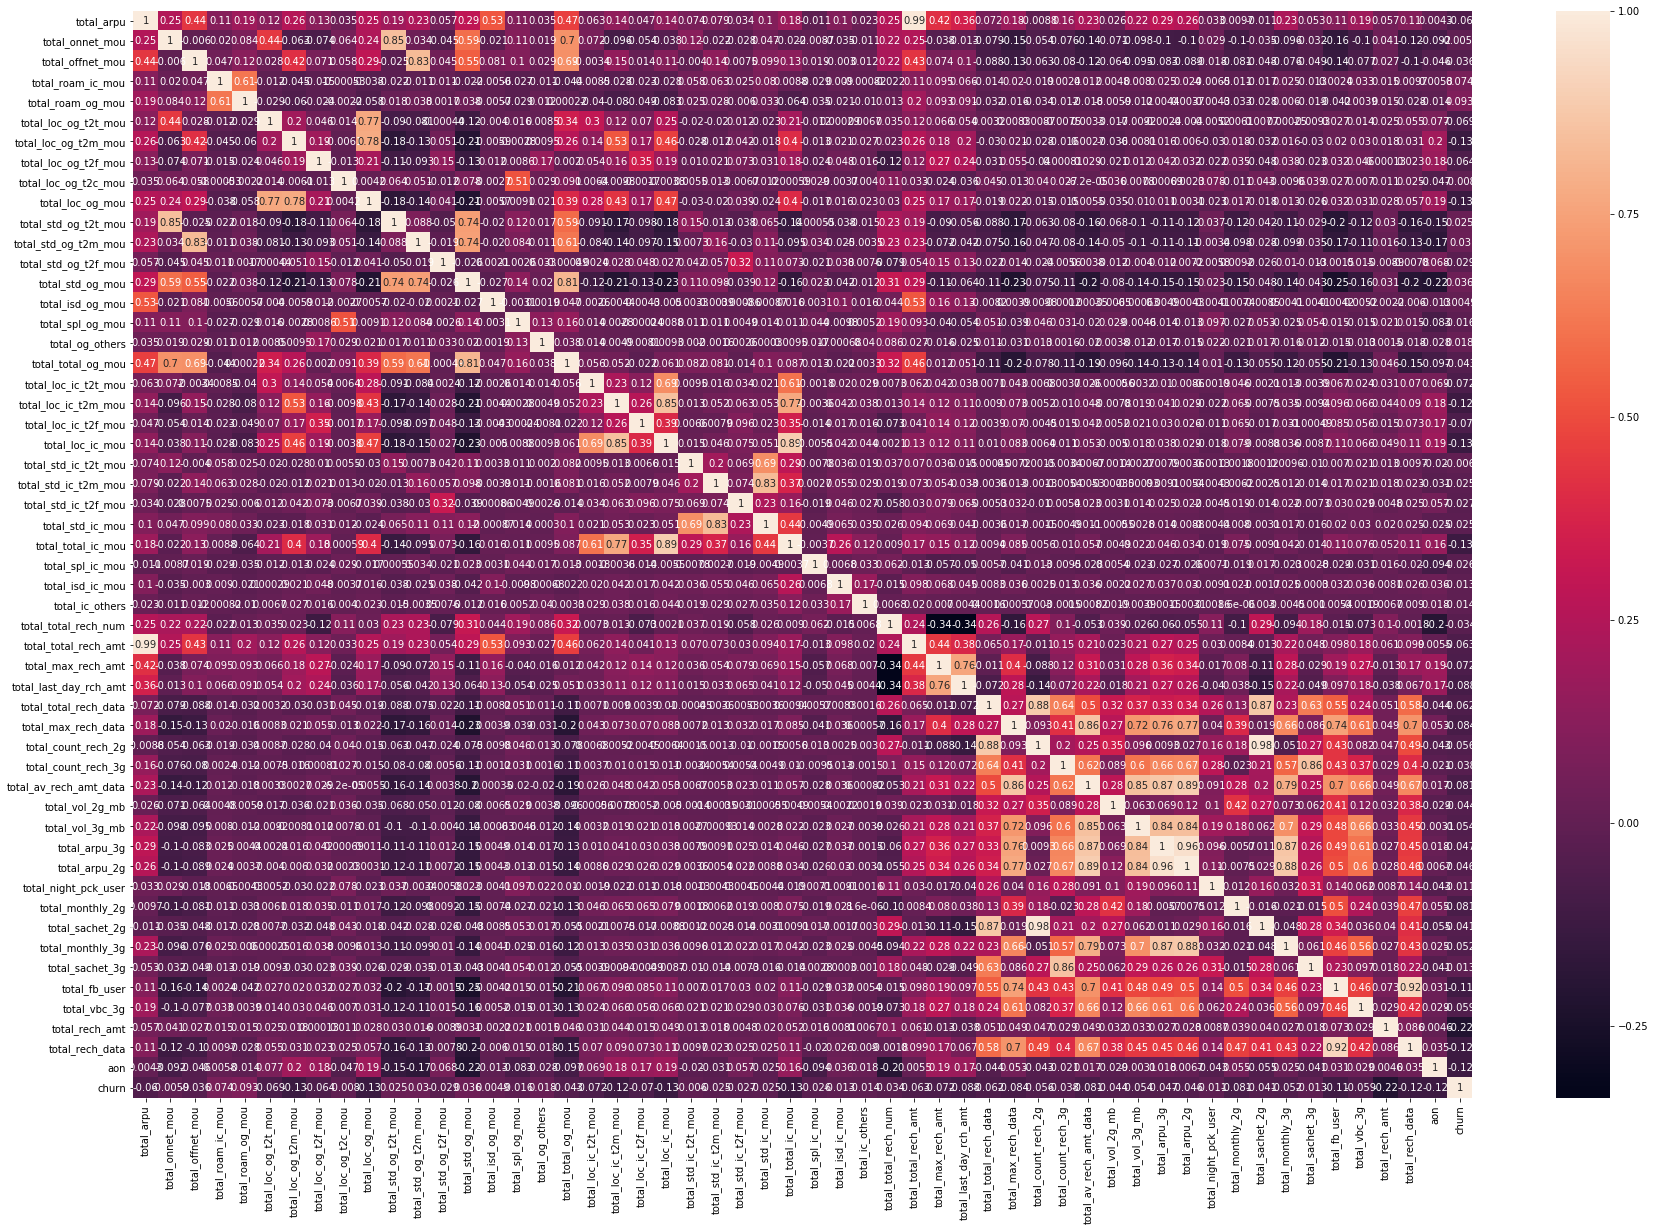

In [75]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
%matplotlib inline
# Let's see the correlation matrix 
plt.figure(figsize = (30,20))        # Size of the figure
sns.heatmap(total_data.corr(),annot = True)

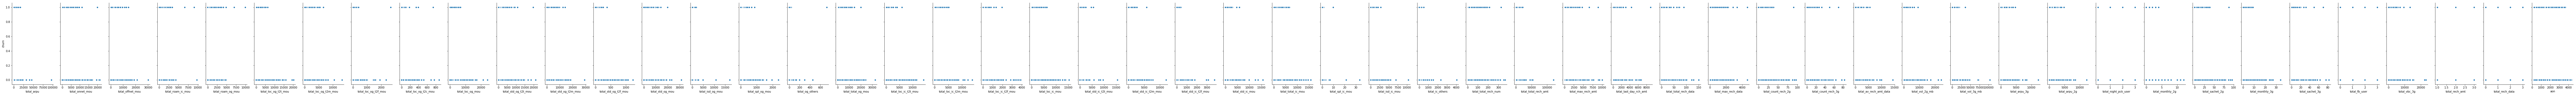

In [76]:
sns.pairplot(total_data, x_vars=total_data.drop('churn', axis=1).columns, y_vars='churn', size=5, aspect=0.5,kind='scatter')

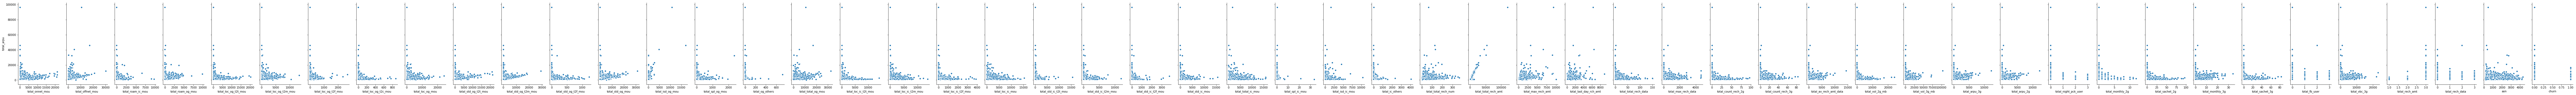

In [77]:
sns.pairplot(total_data, x_vars=total_data.drop('total_arpu', axis=1).columns, y_vars='total_arpu', size=5, aspect=0.5,kind='scatter')

In [78]:
total_data[total_data['total_arpu']>40000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
38610   96420.546            17.84          10725.83                0.0   
51314   46152.276             0.18          17232.18                1.0   
67717   40614.779            37.53           4913.58                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
38610               0.00                 17.84                 11.20   
51314             139.98                  0.18                  0.00   
67717               0.00                 37.53                 43.21   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
38610                  0.00                  0.00             29.06   
51314                  0.60                  9.68              0.78   
67717                  3.35                  0.15             84.11   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
38610                   0.0                  0.18                   0.0   
51314                   0.0                  2.05                   0.0   
67717                   0.0                 11.02                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
38610              0.18          10727.21              0.00              0.0   
51314              2.05          17072.48             19.74              0.0   
67717             11.02           4869.62              0.15              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
38610            10756.48                 35.42                 18.15   
51314            17095.07                  0.59                  0.05   
67717             4964.93                 42.78                 28.20   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
38610                  1.43             55.01                  2.28   
51314                  0.35              0.99                  3.98   
67717                  0.00             71.00                  1.54   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
38610                  5.06                  0.00              7.34   
51314                  0.00                  1.78              5.76   
67717                 35.16                  0.00             36.71   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
38610             1672.78              0.19           1597.74   
51314               10.65              0.41              2.75   
67717              578.33              0.00            470.58   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
38610            12.43                    65                120845   
51314             0.71                   126                 53479   
67717             0.00                   131                 45380   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
38610                9300                    6235                    0.0   
51314                3169                    1500                    2.0   
67717                6550                    6450                    0.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
38610                  0.0                  0.0                  0.0   
51314                504.0                  0.0                  2.0   
67717                  0.0                  0.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
38610                     0.0             0.00             0.00   
51314                   504.0            26.42           833.73   
67717                     0.0             0.00             0.00   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
38610           0.00           0.00                   0.0                 0   
51314         424.34         424.34                   0.0                 0   
67717

In [79]:
total_data[total_data['total_offnet_mou']>30000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
33035    12124.74          2351.28          30177.43                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
33035                0.0                 96.07                352.46   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
33035                  4.93                 23.53            453.48   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
33035                2255.2              29126.03                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
33035          31381.25              0.18             707.7             0.03   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
33035            32542.68                 34.93                157.47   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
33035                 38.28            230.71                 15.26   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
33035                107.46                   0.0            122.75   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
33035              353.91              0.43               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
33035              0.0                   111                 14077   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
33035                 646                     441                    1.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
33035                 14.0                  1.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
33035                    14.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
33035            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
33035                1                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
33035           0.0               3                1  423      0

In [80]:
total_data[total_data['total_roam_ic_mou']>9500]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
28436    1238.586           366.65            887.01             9716.2   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
28436            1099.49                 83.73                 61.58   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
28436                   0.0                  0.58            145.33   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
28436                   3.1                  2.44                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
28436              5.54               0.0              3.28              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
28436              154.17                119.85                 23.09   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
28436                 17.03            159.98                   0.0   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
28436                   4.7                   0.0               4.7   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
28436              164.68               0.0               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
28436              0.0                    23                  1411   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
28436                 365                     365                    4.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
28436                435.0                  0.0                  4.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
28436                   580.0            30.48          1217.47   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
28436         497.88         488.28                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
28436                0                 4                0            3.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
28436        362.96               3                3  383      0

In [81]:
total_data[total_data['total_roam_og_mou']>7500]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
74987      8101.6          8394.67           1502.15              27.66   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
74987            9896.82                   0.0                   0.0   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
74987                   0.0                   0.0               0.0   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
74987                   0.0                   0.0                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
74987               0.0               0.0               0.0              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
74987                 0.0                   0.0                   0.0   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
74987                   0.0               0.0                   0.0   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
74987                   0.0                   0.0               0.0   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
74987                 0.0               0.0               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
74987              0.0                    23                 11354   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
74987                8966                    8966                    0.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
74987                  0.0                  0.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
74987                     0.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
74987            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
74987                0                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
74987           0.0               3                0  300      1

In [82]:
total_data[total_data['total_loc_og_t2f_mou']>2000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
67497    4478.437            29.61           2675.15               0.00   
95046    7318.820           395.73           5203.92              92.46   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
67497                0.0                 29.61                312.41   
95046             1625.7                 40.10                  4.85   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
67497               2357.03                  5.68           2699.10   
95046               2673.84                  0.00           2718.81   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
67497                   0.0                  0.00                  0.00   
95046                 116.7                 10.44                380.41   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
67497              0.00              0.00              8.54             0.00   
95046            507.58             63.27            684.26           720.96   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
67497             2707.65                 86.76                725.88   
95046             4694.95                 16.99                  1.89   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
67497               3296.79           4109.48                  1.24   
95046                  0.00             18.88                 88.92   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
67497                  0.53                  0.00              1.78   
95046                 32.24                112.75            233.93   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
67497             4111.61              0.33              0.01   
95046              339.78              0.00             86.94   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
67497              0.0                    86                  5313   
95046              0.0                    14                  6500   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
67497                 948                     213                    0.0   
95046                3000                    1500                    0.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
67497                  0.0                  0.0                  0.0   
95046                  0.0                  0.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
67497                     0.0              0.0              0.0   
95046                     0.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
67497            0.0            0.0                   0.0                 0   
95046            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
67497                0                 0                0            0.0   
95046                0                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
67497          0.00               3                0  838      0  
95046        151.52               3                0  262      1

In [83]:
total_data[total_data['total_std_og_t2m_mou']>20000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
33035    12124.74          2351.28          30177.43                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
33035                0.0                 96.07                352.46   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
33035                  4.93                 23.53            453.48   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
33035                2255.2              29126.03                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
33035          31381.25              0.18             707.7             0.03   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
33035            32542.68                 34.93                157.47   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
33035                 38.28            230.71                 15.26   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
33035                107.46                   0.0            122.75   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
33035              353.91              0.43               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
33035              0.0                   111                 14077   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
33035                 646                     441                    1.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
33035                 14.0                  1.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
33035                    14.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
33035            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
33035                1                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
33035           0.0               3                1  423      0

In [84]:
total_data[total_data['total_std_og_mou']>30000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
33035    12124.74          2351.28          30177.43                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
33035                0.0                 96.07                352.46   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
33035                  4.93                 23.53            453.48   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
33035                2255.2              29126.03                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
33035          31381.25              0.18             707.7             0.03   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
33035            32542.68                 34.93                157.47   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
33035                 38.28            230.71                 15.26   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
33035                107.46                   0.0            122.75   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
33035              353.91              0.43               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
33035              0.0                   111                 14077   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
33035                 646                     441                    1.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
33035                 14.0                  1.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
33035                    14.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
33035            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
33035                1                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
33035           0.0               3                1  423      0

In [85]:
total_data[total_data['total_isd_og_mou']>15000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
51314   46152.276             0.18          17232.18                1.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
51314             139.98                  0.18                   0.0   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
51314                   0.6                  9.68              0.78   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
51314                   0.0                  2.05                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
51314              2.05          17072.48             19.74              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
51314            17095.07                  0.59                  0.05   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
51314                  0.35              0.99                  3.98   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
51314                   0.0                  1.78              5.76   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
51314               10.65              0.41              2.75   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
51314             0.71                   126                 53479   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
51314                3169                    1500                    2.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
51314                504.0                  0.0                  2.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
51314                   504.0            26.42           833.73   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
51314         424.34         424.34                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
51314                0                 2                0            2.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
51314       1094.61               3                2  289      0

In [86]:
total_data[total_data['total_og_others']>600]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
95046     7318.82           395.73           5203.92              92.46   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
95046             1625.7                  40.1                  4.85   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
95046               2673.84                   0.0           2718.81   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
95046                 116.7                 10.44                380.41   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
95046            507.58             63.27            684.26           720.96   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
95046             4694.95                 16.99                  1.89   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
95046                   0.0             18.88                 88.92   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
95046                 32.24                112.75            233.93   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
95046              339.78               0.0             86.94   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
95046              0.0                    14                  6500   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
95046                3000                    1500                    0.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
95046                  0.0                  0.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
95046                     0.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
95046            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
95046                0                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
95046        151.52               3                0  262      1

In [87]:
total_data[total_data['total_total_og_mou']>30000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
33035    12124.74          2351.28          30177.43                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
33035                0.0                 96.07                352.46   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
33035                  4.93                 23.53            453.48   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
33035                2255.2              29126.03                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
33035          31381.25              0.18             707.7             0.03   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
33035            32542.68                 34.93                157.47   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
33035                 38.28            230.71                 15.26   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
33035                107.46                   0.0            122.75   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
33035              353.91              0.43               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
33035              0.0                   111                 14077   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
33035                 646                     441                    1.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
33035                 14.0                  1.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
33035                    14.0              0.0              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
33035            0.0            0.0                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
33035                1                 0                0            0.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
33035           0.0               3                1  423      0

In [88]:
total_data[total_data['total_loc_ic_t2t_mou']>12000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
34952    2785.079          1438.76           1142.54                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
34952                0.0               1201.29                536.78   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
34952                  36.3                 35.29            1774.4   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
34952                237.02                441.22                 10.02   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
34952            688.28               0.0            129.35             2.14   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
34952             2594.21              14126.61                 813.2   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
34952                353.55           15293.4                317.55   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
34952                345.94                 24.33            687.87   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
34952            16000.67               0.0             13.99   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
34952              5.4                    44                  3113   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
34952                 395                     395                    1.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
34952                175.0                  1.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
34952                   175.0            57.18             1.66   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
34952            0.0            7.4                   0.0                 1   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
34952                0                 0                0            1.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
34952          1.89               3                1  605      0

In [89]:
total_data[total_data['total_std_ic_t2m_mou']>10000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
12898    2019.799           421.58           3518.78              24.13   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
12898              16.85                 24.83                233.33   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
12898                   0.0                 39.01            258.18   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
12898                396.74               3215.29                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
12898           3612.05               0.0             71.63              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
12898              3941.9                  31.3                182.78   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
12898                   0.0            214.09                563.71   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
12898              11891.03                 27.05          12481.83   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
12898            12695.95               0.0               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
12898              0.0                    38                  2383   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
12898                 450                     111                    2.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
12898                 14.0                  2.0                  0.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
12898                    28.0            57.92              0.0   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
12898            0.0           5.15                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
12898                2                 0                0            1.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
12898           0.0               3                1  221      0

In [90]:
total_data[total_data['total_isd_ic_mou']>7500]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
83599     3386.16            111.6             578.2                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
83599                0.0                111.27                392.88   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
83599                138.38                 13.34            642.56   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
83599                   0.0                  0.78                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
83599              0.78             43.57             13.34              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
83599              700.29                 91.67                385.11   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
83599                 29.85            506.66                  0.56   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
83599                 27.51                 29.35             57.42   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
83599            11009.48              0.33          10375.71   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
83599            69.28                    20                  3918   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
83599                1662                     500                    6.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
83599               1662.0                  0.0                  6.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
83599                  2418.0             30.7         12787.07   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
83599        2218.95         2052.5                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
83599                0                 6                0            3.0   

       total_vbc_3g  total_rech_amt  total_rech_data   aon  churn  
83599       5523.35               3                3  2372      0

In [91]:
total_data[total_data['total_arpu_2g']>10000]

total_arpu  total_onnet_mou  total_offnet_mou  total_roam_ic_mou  \
27531    12204.97              0.0             11.92                0.0   

       total_roam_og_mou  total_loc_og_t2t_mou  total_loc_og_t2m_mou  \
27531                0.0                   0.0                  0.53   

       total_loc_og_t2f_mou  total_loc_og_t2c_mou  total_loc_og_mou  \
27531                   0.0                 10.24              0.53   

       total_std_og_t2t_mou  total_std_og_t2m_mou  total_std_og_t2f_mou  \
27531                   0.0                   0.0                   0.0   

       total_std_og_mou  total_isd_og_mou  total_spl_og_mou  total_og_others  \
27531               0.0               0.0             11.39              0.0   

       total_total_og_mou  total_loc_ic_t2t_mou  total_loc_ic_t2m_mou  \
27531               11.92                   0.0                   0.0   

       total_loc_ic_t2f_mou  total_loc_ic_mou  total_std_ic_t2t_mou  \
27531                   0.0               0.0                   0.0   

       total_std_ic_t2m_mou  total_std_ic_t2f_mou  total_std_ic_mou  \
27531                   0.0                   0.0               0.0   

       total_total_ic_mou  total_spl_ic_mou  total_isd_ic_mou  \
27531                0.03              0.03               0.0   

       total_ic_others  total_total_rech_num  total_total_rech_amt  \
27531              0.0                    15                 14376   

       total_max_rech_amt  total_last_day_rch_amt  total_total_rech_data  \
27531                4665                    4665                   10.0   

       total_max_rech_data  total_count_rech_2g  total_count_rech_3g  \
27531               4665.0                  0.0                 10.0   

       total_av_rech_amt_data  total_vol_2g_mb  total_vol_3g_mb  \
27531                 14346.0             0.27        103371.75   

       total_arpu_3g  total_arpu_2g  total_night_pck_user  total_monthly_2g  \
27531        12248.3       12248.25                   0.0                 0   

       total_sachet_2g  total_monthly_3g  total_sachet_3g  total_fb_user  \
27531                0                10                0            3.0   

       total_vbc_3g  total_rech_amt  total_rech_data  aon  churn  
27531       6445.67               3                3  222      0

In [92]:
high_value_cust = high_value_cust.drop(total_data[total_data['total_arpu']>40000].index)
total_data = total_data.drop(total_data[total_data['total_arpu']>40000].index)


high_value_cust = high_value_cust.drop(total_data[total_data['total_offnet_mou']>30000].index)
total_data = total_data.drop(total_data[total_data['total_offnet_mou']>30000].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_roam_ic_mou']>9500].index)
total_data = total_data.drop(total_data[total_data['total_roam_ic_mou']>9500].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_roam_og_mou']>7500].index)
total_data = total_data.drop(total_data[total_data['total_roam_og_mou']>7500].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_loc_og_t2f_mou']>2000].index)
total_data = total_data.drop(total_data[total_data['total_loc_og_t2f_mou']>2000].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_loc_ic_t2t_mou']>12000].index)
total_data = total_data.drop(total_data[total_data['total_loc_ic_t2t_mou']>12000].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_std_ic_t2m_mou']>10000].index)
total_data = total_data.drop(total_data[total_data['total_std_ic_t2m_mou']>10000].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_isd_ic_mou']>7500].index)
total_data = total_data.drop(total_data[total_data['total_isd_ic_mou']>7500].index)

high_value_cust = high_value_cust.drop(total_data[total_data['total_arpu_2g']>10000].index)
total_data = total_data.drop(total_data[total_data['total_arpu_2g']>10000].index)

In [93]:
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Columns: 167 entries, last_date_of_month_6 to rech_data_8
dtypes: datetime64[ns](9), float64(126), int64(32)
memory usage: 38.4 MB


In [94]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Data columns (total 54 columns):
total_arpu                29967 non-null float64
total_onnet_mou           29967 non-null float64
total_offnet_mou          29967 non-null float64
total_roam_ic_mou         29967 non-null float64
total_roam_og_mou         29967 non-null float64
total_loc_og_t2t_mou      29967 non-null float64
total_loc_og_t2m_mou      29967 non-null float64
total_loc_og_t2f_mou      29967 non-null float64
total_loc_og_t2c_mou      29967 non-null float64
total_loc_og_mou          29967 non-null float64
total_std_og_t2t_mou      29967 non-null float64
total_std_og_t2m_mou      29967 non-null float64
total_std_og_t2f_mou      29967 non-null float64
total_std_og_mou          29967 non-null float64
total_isd_og_mou          29967 non-null float64
total_spl_og_mou          29967 non-null float64
total_og_others           29967 non-null float64
total_total_og_mou        29967 non-null float64
total_loc

In [95]:
goodvsaction_df = pd.DataFrame()

In [96]:
for col in collist:
    goodvsaction_df['good_action_'+col] = high_value_cust[[col+'_6',col+'_7',col+'_8']].apply(lambda x: 1 if (((x[col+'_6']+x[col+'_7'])/2) >= (x[col+'_8'])) else 0, axis=1)

In [97]:
goodvsaction_df.head()

good_action_arpu  good_action_onnet_mou  good_action_offnet_mou  \
7                  0                      1                       1   
8                  1                      1                       0   
13                 0                      0                       0   
16                 1                      0                       1   
17                 1                      1                       1   

    good_action_roam_ic_mou  good_action_roam_og_mou  \
7                         0                        0   
8                         1                        1   
13                        1                        1   
16                        1                        1   
17                        0                        0   

    good_action_loc_og_t2t_mou  good_action_loc_og_t2m_mou  \
7                            1                           1   
8                            1                           1   
13                           0                           0   
16                           0                           1   
17                           1                           1   

    good_action_loc_og_t2f_mou  good_action_loc_og_t2c_mou  \
7                            1                           1   
8                            1                           0   
13                           0                           0   
16                           0                           1   
17                           1                           1   

    good_action_loc_og_mou  good_action_std_og_t2t_mou  \
7                        1                           1   
8                        1                           1   
13                       0                           0   
16                       1                           1   
17                       1                           1   

    good_action_std_og_t2m_mou  good_action_std_og_t2f_mou  \
7                            0                           0   
8                            0                           1   
13                           0                           1   
16                           1                           1   
17                           1                           1   

    good_action_std_og_mou  good_action_isd_og_mou  good_action_spl_og_mou  \
7                        0                       0                       0   
8                        1                       1                       0   
13                       0                       0                       0   
16                       1                       1                       0   
17                       1                       1                       1   

    good_action_og_others  good_action_total_og_mou  \
7                       1                         1   
8                       1                         1   
13                      1                         0   
16                      1                         1   
17                      1                         1   

    good_action_loc_ic_t2t_mou  good_action_loc_ic_t2m_mou  \
7                            1                           1   
8                            1                           1   
13                           0                           0   
16                           1                           1   
17                           1                           1   

    good_action_loc_ic_t2f_mou  good_action_loc_ic_mou  \
7                            1                       1   
8                            1                       1   
13                           0                       0   
16                           0                       1   
17                           1                       1   

    good_action_std_ic_t2t_mou  good_action_std_ic_t2m_mou  \
7                            0                           0   
8                            1                           1   
13                           0                           0   
16

In [98]:
total_data['in_out_difference']=total_data['total_total_ic_mou']-total_data['total_total_og_mou']

In [99]:
total_data['onnet_offnet_difference'] = total_data['total_onnet_mou']-total_data['total_offnet_mou']

In [100]:
len(total_data[total_data['total_arpu']==0])

0

In [101]:
len(total_data[total_data['total_arpu_2g']+total_data['total_arpu_3g']==0])

16459

In [102]:
total_data['arpu_data_to_total_ratio'] = (total_data['total_arpu_2g']+total_data['total_arpu_3g'])/total_data['total_arpu']

In [103]:
len(total_data[total_data['arpu_data_to_total_ratio']==0])

16459

In [104]:
len(total_data[total_data['total_total_rech_amt']==0])

0

In [105]:
len(total_data[total_data['total_av_rech_amt_data']==0])

14313

In [106]:
total_data['data_to_amt_ratio']=total_data['total_av_rech_amt_data']/total_data['total_total_rech_amt']

In [107]:
total_data=total_data.drop(['aon','churn'], axis=1)

In [108]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Data columns (total 56 columns):
total_arpu                  29967 non-null float64
total_onnet_mou             29967 non-null float64
total_offnet_mou            29967 non-null float64
total_roam_ic_mou           29967 non-null float64
total_roam_og_mou           29967 non-null float64
total_loc_og_t2t_mou        29967 non-null float64
total_loc_og_t2m_mou        29967 non-null float64
total_loc_og_t2f_mou        29967 non-null float64
total_loc_og_t2c_mou        29967 non-null float64
total_loc_og_mou            29967 non-null float64
total_std_og_t2t_mou        29967 non-null float64
total_std_og_t2m_mou        29967 non-null float64
total_std_og_t2f_mou        29967 non-null float64
total_std_og_mou            29967 non-null float64
total_isd_og_mou            29967 non-null float64
total_spl_og_mou            29967 non-null float64
total_og_others             29967 non-null float64
total_total_og_mou      

In [109]:
goodvsaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Data columns (total 52 columns):
good_action_arpu                29967 non-null int64
good_action_onnet_mou           29967 non-null int64
good_action_offnet_mou          29967 non-null int64
good_action_roam_ic_mou         29967 non-null int64
good_action_roam_og_mou         29967 non-null int64
good_action_loc_og_t2t_mou      29967 non-null int64
good_action_loc_og_t2m_mou      29967 non-null int64
good_action_loc_og_t2f_mou      29967 non-null int64
good_action_loc_og_t2c_mou      29967 non-null int64
good_action_loc_og_mou          29967 non-null int64
good_action_std_og_t2t_mou      29967 non-null int64
good_action_std_og_t2m_mou      29967 non-null int64
good_action_std_og_t2f_mou      29967 non-null int64
good_action_std_og_mou          29967 non-null int64
good_action_isd_og_mou          29967 non-null int64
good_action_spl_og_mou          29967 non-null int64
good_action_og_others           29967 non-n

In [110]:
high_value_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Columns: 167 entries, last_date_of_month_6 to rech_data_8
dtypes: datetime64[ns](9), float64(126), int64(32)
memory usage: 38.4 MB


In [111]:
final_data = pd.concat([high_value_cust, total_data], axis=1)

In [112]:
final_data = pd.concat([final_data, goodvsaction_df], axis=1)

In [113]:
final_data.columns.tolist()

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_oth

In [114]:
final_data.head(5)

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
7            2014-06-30           2014-07-31           2014-08-31  1069.180   
8            2014-06-30           2014-07-31           2014-08-31   378.721   
13           2014-06-30           2014-07-31           2014-08-31   492.846   
16           2014-06-30           2014-07-31           2014-08-31   430.975   
17           2014-06-30           2014-07-31           2014-08-31   690.008   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
13   205.671   593.260       501.76       108.39       534.24        413.31   
16   299.869   187.894        50.51        74.01        70.61        296.29   
17    18.980    25.499      1185.91         9.28         7.79         61.64   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
13        119.28        482.46          23.53         144.24          72.11   
16        229.74        162.76           0.00           2.83           0.00   
17          0.00          5.54           0.00           4.76           4.81   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
13           7.98          35.26           1.44             49.63   
16           0.00          17.74           0.00             42.61   
17           0.00           8.46          13.34             38.99   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
13              6.19             36.01            151.13             47.28   
16             65.16             67.38            273.29            145.99   
17              0.00              0.00             58.54              0.00   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
13            294.46              4.54              0.00             23.51   
16            128.28              0.00              4.48             10.26   
17              0.00              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
13               0.0               0.0              0.49        205.31   
16               0.0               0.0              0.00        315.91   
17               0.0               0.0              0.00         97.54   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
13         53.48        353.99            446.41             85.98   
16        215.64        205.93              7.89              2.58   
17          0.00          0.00           1146.91              0.81   

    std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
7              12.01             49.89             31.76             49.14   
8              22.58             13.69             10.04             75.69   
13            498.23            255.36             52.94            156.94   
16              3.23             22.99         

In [115]:
final_data.select_dtypes(include=['datetime64[ns]','object']).columns.tolist()

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [116]:
final_data = final_data.drop(final_data.select_dtypes(include=['datetime64[ns]','object']).columns.tolist(), axis=1)

In [117]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 7 to 99997
Columns: 266 entries, arpu_6 to good_action_rech_data
dtypes: float64(172), int64(94)
memory usage: 61.0 MB


In [118]:
final_data['churn']=final_data['churn'].astype(int)

In [119]:
round(100*(final_data.isnull().sum()/len(final_data.index)), 2).sum()

0.0

In [120]:
from sklearn.preprocessing import scale


In [121]:
X=pd.DataFrame(scale(final_data.drop('churn',axis=1)))
y = final_data['churn']
X.columns=final_data.drop('churn',axis=1).columns

In [122]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

c:\python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [123]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

In [124]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01, class_weight='balanced', penalty='l1')
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [125]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, lr.predict(X_test))

0.8368368368368369

In [126]:
from sklearn.metrics import f1_score
f1_score(y_test, lr.predict(X_test))

0.4678998911860718

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, lr.predict(X_train))

array([[11133,  2238],
       [  173,  1139]], dtype=int64)

In [128]:
majorpredictors=[]
counter = 0
for col in X_train.columns.tolist():
    if(lr.coef_[0][counter] > 0.01):
        print(str(lr.coef_[0][counter]),'-',col)
        majorpredictors.append(col)
    counter+=1
  

0.16843122141987577 - arpu_7
0.12231526988520997 - roam_ic_mou_6
0.06682588583710732 - roam_og_mou_6
0.10273120223403194 - roam_og_mou_7
0.043694827896644896 - std_og_mou_6
0.027357861284867065 - isd_og_mou_8
0.0112303648734331 - loc_ic_t2m_mou_7
0.025757289377275283 - loc_ic_mou_7
0.012707397202808019 - isd_ic_mou_6
0.06244314083652103 - total_rech_num_7
0.06376073234567325 - total_rech_amt_6
0.02536667156779251 - max_rech_amt_7
0.06254568316061865 - max_rech_data_7
0.06847730038070533 - total_isd_og_mou
0.0854458620674246 - good_action_onnet_mou
0.04741832695611795 - good_action_offnet_mou
0.07734340845478542 - good_action_loc_og_t2m_mou
0.17639060809802729 - good_action_loc_og_t2f_mou
0.07841358422612091 - good_action_std_og_t2f_mou
0.022852703995342668 - good_action_spl_og_mou
0.1420302085237112 - good_action_loc_ic_t2t_mou
0.20910375851233173 - good_action_loc_ic_t2m_mou
0.04539981084136268 - good_action_loc_ic_t2f_mou
0.13290481827932682 - good_action_std_ic_t2t_mou
0.12137373744

In [129]:
majorpredictors

['arpu_7',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'std_og_mou_6',
 'isd_og_mou_8',
 'loc_ic_t2m_mou_7',
 'loc_ic_mou_7',
 'isd_ic_mou_6',
 'total_rech_num_7',
 'total_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_data_7',
 'total_isd_og_mou',
 'good_action_onnet_mou',
 'good_action_offnet_mou',
 'good_action_loc_og_t2m_mou',
 'good_action_loc_og_t2f_mou',
 'good_action_std_og_t2f_mou',
 'good_action_spl_og_mou',
 'good_action_loc_ic_t2t_mou',
 'good_action_loc_ic_t2m_mou',
 'good_action_loc_ic_t2f_mou',
 'good_action_std_ic_t2t_mou',
 'good_action_std_ic_t2f_mou',
 'good_action_std_ic_mou',
 'good_action_ic_others',
 'good_action_max_rech_amt',
 'good_action_last_day_rch_amt',
 'good_action_vol_2g_mb',
 'good_action_vol_3g_mb']

In [130]:
import statsmodels.api as sm                        # Importing statsmodels
X_train_model = sm.add_constant(X_train)     
lm_stats = sm.GLM(list(y_train),X_train_model, family=sm.families.Binomial()).fit()

In [131]:
p_values = pd.DataFrame()
p_values["features"]=lm_stats.pvalues.index
p_values["p_value"]=lm_stats.pvalues.values
p_values = p_values.sort_values('p_value', ascending = False)

In [132]:
p_values = p_values[p_values.features != 'const']
len(p_values[~p_values["features"].isin(majorpredictors)])

234

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
X_train_reduce = X_train
#p_values = pd.DataFrame()

for j in range(1,250):
    p_values = pd.DataFrame()
    vif = pd.DataFrame()
    X_train_model = sm.add_constant(X_train_reduce)     
    lm_stats = sm.GLM(list(y_train),X_train_model, family=sm.families.Binomial()).fit()
    p_values["features"]=lm_stats.pvalues.index
    p_values["p_value"]=lm_stats.pvalues.values
    p_values = p_values.sort_values('p_value', ascending = False)
    vif["VIF Factor"] = [variance_inflation_factor(X_train_reduce.values, i) for i in range(X_train_reduce.shape[1])]
    vif["features"] = X_train_reduce.columns
    vif = vif.sort_values('VIF Factor', ascending = False)
    result = pd.merge(vif[~vif["features"].isin(majorpredictors)],p_values[~p_values["features"].isin(majorpredictors)],on='features')
    result = result.sort_values(['VIF Factor','p_value'], ascending = False)
    if(len(result)<=30):
        break
    else:
        X_train_reduce = X_train_reduce.drop(result.head(1).features, axis=1)                          
        lm = LogisticRegression()
        lm.fit(X_train_reduce,y_train)
        fpr, tpr, thresholds = roc_curve(y_train, lm.predict(X_train_reduce))
        print(str(j),'-',str(auc(fpr, tpr)),'-',str(fpr),'-',str(tpr))

In [133]:
from sklearn.feature_selection import RFE
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
X_train_reduce = X_train
lm = LogisticRegression()
rfe = RFE(lm, 100)                   # running RFE
rfe = rfe.fit(X_train, y_train)
X_train_reduce = X_train.drop(X_train.columns[~rfe.support_].tolist(),1)
lm.fit(X_train_reduce,y_train)
fpr, tpr, thresholds = roc_curve(y_train, lm.predict(X_train_reduce))
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, lm.predict(X_val.drop(X_val.columns[~rfe.support_].tolist(),1)))
#print(fpr)
#print(tpr)
print(str(auc(fpr, tpr)),'-',str(auc(fpr_val, tpr_val)))

0.6987521399151058 - 0.681455675150313


In [134]:
X_train_reduce.corr()

arpu_6    arpu_7    arpu_8  onnet_mou_6  \
arpu_6                        1.000000  0.552065  0.481474     0.327719   
arpu_7                        0.552065  1.000000  0.673434     0.160467   
arpu_8                        0.481474  0.673434  1.000000     0.095285   
onnet_mou_6                   0.327719  0.160467  0.095285     1.000000   
offnet_mou_7                  0.255021  0.479466  0.318934    -0.059531   
roam_ic_mou_6                 0.118052  0.089406  0.080968     0.004383   
roam_og_mou_6                 0.199903  0.137503  0.121586     0.061573   
roam_og_mou_7                 0.139482  0.188277  0.136680     0.058707   
roam_og_mou_8                 0.105760  0.154544  0.201529     0.052951   
loc_og_t2t_mou_6              0.147296  0.082975  0.081483     0.449001   
loc_og_t2t_mou_8              0.103689  0.121943  0.175392     0.309718   
loc_og_t2m_mou_6              0.322818  0.188854  0.176392    -0.036283   
loc_og_t2f_mou_7              0.092114  0.119217  0.125264    -0.076162   
loc_og_t2f_mou_8              0.082436  0.095308  0.159353    -0.071821   
loc_og_mou_8                  0.193505  0.240025  0.355058     0.151802   
std_og_t2t_mou_6              0.259835  0.118436  0.048636     0.844346   
std_og_t2m_mou_7              0.131815  0.317960  0.182334    -0.018157   
isd_og_mou_7                  0.207480  0.282130  0.232859    -0.033495   
spl_og_mou_8                  0.024562  0.062698  0.086479     0.054933   
og_others_8                  -0.009509  0.002860 -0.003329    -0.010129   
loc_ic_t2m_mou_6              0.179955  0.095244  0.092206    -0.070137   
loc_ic_t2m_mou_8              0.108609  0.149641  0.220862    -0.094254   
loc_ic_t2f_mou_6              0.052161  0.021684  0.043555    -0.045838   
loc_ic_t2f_mou_8              0.032352  0.034670  0.076296    -0.053333   
loc_ic_mou_7                  0.111977  0.159161  0.141310    -0.033082   
loc_ic_mou_8                  0.103550  0.143757  0.218986    -0.041933   
std_ic_t2t_mou_6              0.072827  0.044248  0.031396     0.119739   
std_ic_t2t_mou_7              0.036458  0.078885  0.054773     0.075286   
std_ic_t2t_mou_8              0.041616  0.089525  0.090561     0.066083   
std_ic_t2m_mou_7              0.033637  0.090939  0.064398    -0.031216   
std_ic_t2m_mou_8              0.035203  0.092628  0.107453    -0.030899   
total_ic_mou_8                0.119154  0.182405  0.260195    -0.038770   
spl_ic_mou_8                 -0.025758 -0.015046  0.007206    -0.024309   
isd_ic_mou_7                  0.051090  0.084090  0.096282    -0.026300   
total_rech_num_7              0.111768  0.337274  0.190597     0.105716   
total_rech_num_8              0.091316  0.233558  0.386462     0.091606   
total_rech_amt_6              0.935835  0.553382  0.476490     0.306612   
max_rech_amt_8                0.227174  0.332931  0.431196    -0.046210   
total_rech_data_6             0.085746  0.034295  0.037212    -0.084313   
total_rech_data_8             0.024212  0.061944  0.131015    -0.079720   
max_rech_data_6               0.187525  0.111663  0.123495    -0.138464   
max_rech_data_7               0.093117  0.218444  0.154552    -0.146638   
max_rech_data_8               0.118017  0.170431  0.256721    -0.129019   
count_rech_3g_6               0.159199  0.110596  0.098902    -0.076215   
count_rech_3g_8               0.096231  0.149635  0.209022    -0.076758   
vol_2g_mb_6                   0.039369  0.004166  0.017167    -0.065814   
vol_2g_mb_8                   0.009240  0.037715  0.075401    -0.056431   
arpu_3g_6                     0.299366  0.200134  0.181083    -0.095890   
arpu_3g_7                     0.166723  0.371930  0.221864    -0.096418   
arpu_3g_8                     0.181039  0.254259  0.349931    -0.090477   
arpu_2g_6                     0.273314  0.175554  0.159604    -0.098909   
arpu_2g_7                     0.151033  0.342143  0.206733    -0.097716   
arpu_2g_8                     0.165982  0.237835  0.32729

In [135]:
p_values = pd.DataFrame()
vif = pd.DataFrame()
X_train_model = sm.add_constant(X_train_reduce)     
lm_stats = sm.GLM(list(y_train),X_train_model, family=sm.families.Binomial()).fit()
p_values["features"]=lm_stats.pvalues.index
p_values["p_value"]=lm_stats.pvalues.values
p_values = p_values.sort_values('p_value', ascending = False)
vif["VIF Factor"] = [variance_inflation_factor(X_train_reduce.values, i) for i in range(X_train_reduce.shape[1])]
vif["features"] = X_train_reduce.columns

NameError: name 'variance_inflation_factor' is not defined

In [ ]:
result = pd.merge(vif,p_values,on='features')

In [ ]:
result

In [ ]:
result['features'].isin(majorpredictors)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
X_train_reduce = X_train
for i in range(25,1,-1):
    lm = LogisticRegression()
    rfe = RFE(lm, i*10)                   # running RFE
    rfe = rfe.fit(X_train, y_train)
    X_train_reduce = X_train.drop(X_train.columns[~rfe.support_].tolist(),1)
    lm.fit(X_train_reduce,y_train)
    fpr, tpr, thresholds = roc_curve(y_train, lm.predict(X_train_reduce))
    #print(fpr)
    #print(tpr)
    print(str(i*10),'-',str(auc(fpr, tpr)),'-',str(fpr),'-',str(tpr))
   
    

In [136]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [137]:
#Doing the PCA on the train data
pca.fit(X_train_reduce)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [138]:
pca.components_

array([[ 5.26242717e-02,  7.00752410e-02,  8.36062431e-02, ...,
        -1.30733372e-01, -6.83121674e-02, -4.00634908e-02],
       [ 6.29645769e-02,  1.16335743e-01,  2.04144150e-01, ...,
        -2.72632695e-02, -1.15538843e-02, -6.23495197e-02],
       [ 1.50736051e-01,  6.60335719e-02, -3.04739431e-02, ...,
         3.85541832e-02,  1.20503296e-01,  1.12071631e-01],
       ...,
       [-4.94268046e-03,  1.17508146e-02, -1.63353526e-02, ...,
         5.00815462e-03,  2.26571095e-03,  1.22067841e-03],
       [ 5.08990408e-03, -5.40270577e-03,  3.44954165e-03, ...,
        -9.67357809e-04, -1.16683391e-03, -7.90261661e-04],
       [-2.85756713e-03,  2.62591174e-03, -6.12765583e-05, ...,
         4.37890421e-04,  3.79575437e-04,  2.76980607e-04]])

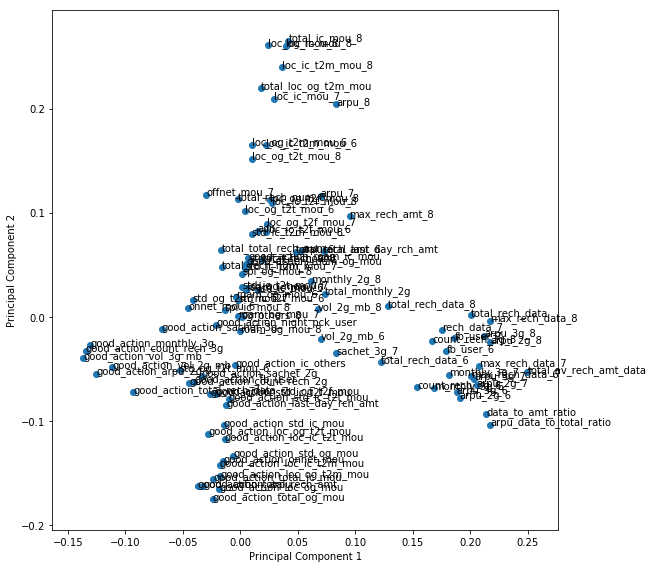

In [139]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pca.components_[0],pca.components_[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(X_train_reduce.columns):
    plt.annotate(txt, (pca.components_[0][i],pca.components_[1][i]))
plt.tight_layout()
plt.show()

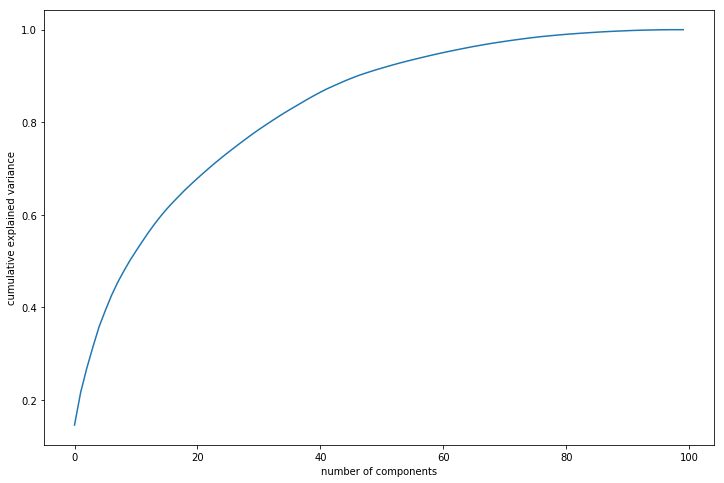

In [140]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

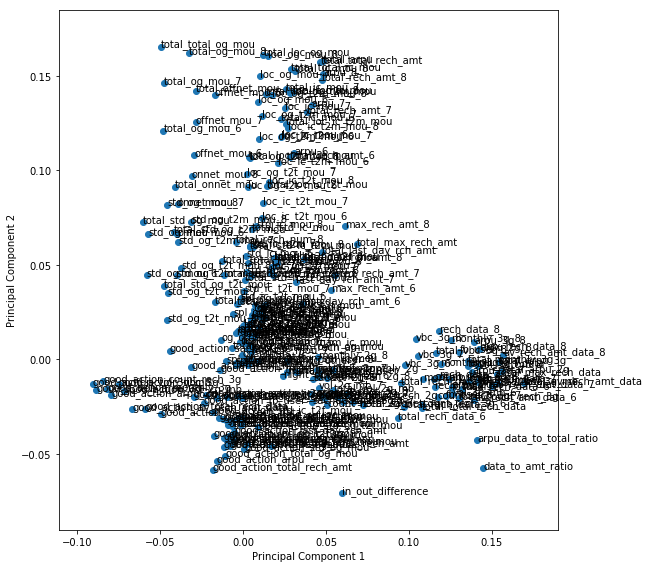

In [141]:
pca.fit(X_train)
fig = plt.figure(figsize = (8,8))
plt.scatter(pca.components_[0],pca.components_[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(X_train.columns):
    plt.annotate(txt, (pca.components_[0][i],pca.components_[1][i]))
plt.tight_layout()
plt.show()

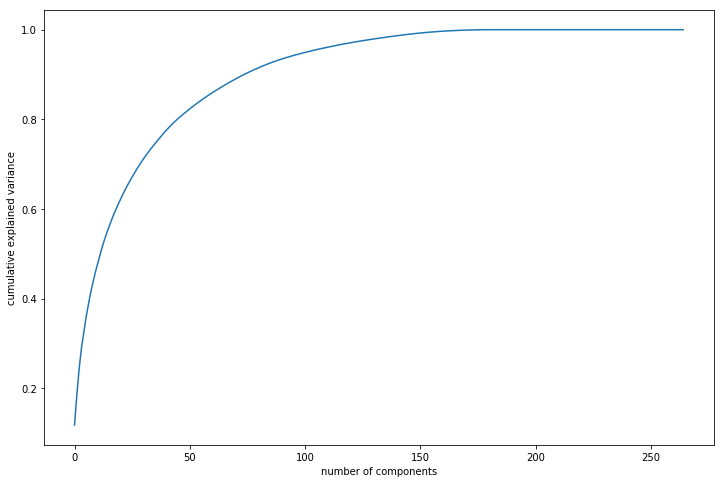

In [142]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [143]:
np.cumsum(pca.explained_variance_ratio_)

array([0.11811199, 0.1850374 , 0.24313841, 0.28959271, 0.32440427,
       0.35771163, 0.38640932, 0.41362354, 0.43604655, 0.45808942,
       0.47740227, 0.49657091, 0.51480315, 0.53160446, 0.54684379,
       0.56092637, 0.57450615, 0.58792665, 0.59983316, 0.61136053,
       0.6223513 , 0.63314074, 0.6432709 , 0.65323665, 0.66246422,
       0.67144131, 0.68017267, 0.68885467, 0.69705135, 0.70484516,
       0.71237093, 0.71983236, 0.72688493, 0.73361133, 0.74007621,
       0.74645134, 0.75276184, 0.75898783, 0.76516964, 0.77109538,
       0.77667903, 0.78214348, 0.78747741, 0.79268909, 0.79749967,
       0.80204054, 0.80654296, 0.81089374, 0.81515717, 0.8193543 ,
       0.82347433, 0.82754159, 0.83145698, 0.83528285, 0.83904256,
       0.84274385, 0.84636518, 0.84995015, 0.85348405, 0.85688019,
       0.86019629, 0.86346872, 0.86669003, 0.86984406, 0.87292108,
       0.87597675, 0.87898837, 0.88193965, 0.88484169, 0.88771604,
       0.89055256, 0.89334032, 0.8960704 , 0.8987689 , 0.90132

In [144]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=100)

In [145]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(14683, 100)

In [146]:
df_val_pca = pca_final.fit_transform(X_val)
df_val_pca.shape

(6293, 100)

In [147]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [148]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [149]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix

In [150]:
# Let's check the report of our default model
print(classification_report(y_train,rfc.predict(X_train)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     13371
          1       1.00      0.93      0.96      1312

avg / total       0.99      0.99      0.99     14683



In [151]:
# Printing confusion matrix
print(confusion_matrix(y_train,rfc.predict(X_train)))

[[13368     3]
 [   87  1225]]


In [152]:
# Let's check the report of our default model
print(classification_report(y_val,rfc.predict(X_val)))

             precision    recall  f1-score   support

          0       0.95      0.98      0.97      5787
          1       0.69      0.47      0.56       506

avg / total       0.93      0.94      0.94      6293



In [153]:
# Printing confusion matrix
print(confusion_matrix(y_val,rfc.predict(X_val)))

[[5680  107]
 [ 268  238]]


In [154]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5
scoring = {'AUC': 'roc_auc'}
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
grid_search = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

In [155]:
pd.DataFrame(train_results).head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.241264         0.011864         0.883703          0.887194   
1       0.574793         0.014108         0.917576          0.957512   
2       0.926276         0.011793         0.906892          0.992131   
3       0.792267         0.008112         0.886848          0.999306   

  param_max_depth             params  rank_test_score  split0_test_score  \
0               2   {'max_depth': 2}                4           0.874429   
1               7   {'max_depth': 7}                1           0.918446   
2              12  {'max_depth': 12}                2           0.914454   
3              17  {'max_depth': 17}                3           0.891702   

   split0_train_score  split1_test_score  split1_train_score  \
0            0.867890           0.890325            0.891904   
1            0.960413           0.914086            0.960255   
2            0.993728           0.897917            0.994337   
3            0.999406           0.869855            0.998876   

   split2_test_score  split2_train_score  split3_test_score  \
0           0.862737            0.889077           0.888288   
1           0.901270            0.956508           0.922837   
2           0.889343            0.988413           0.914329   
3           0.868343            0.999447           0.906082   

   split3_train_score  split4_test_score  split4_train_score  std_fit_time  \
0            0.898943           0.902742            0.888158      0.050964   
1            0.953842           0.931244            0.956544      0.086435   
2            0.992905           0.918416            0.991272      0.180242   
3            0.999329           0.898262            0.999473      0.078515   

   std_score_time  std_test_score  std_train_score  
0        0.003228        0.013804         0.010367  
1        0.010342        0.009932         0.002504  
2        0.006127        0.011258         0.002125  
3        0.007067        0.015198         0.000220

In [156]:
fpr, tpr, thresholds = roc_curve(y_val, grid_search.predict(X_val))
auc(fpr, tpr)

0.7512791038384385

In [159]:
auc_list = []
feature_list=[]
for feature in range(2, 20, 5):
    rf = RandomForestClassifier(max_depth=feature)
    rf.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, rf.predict(X_val))
    auc_list.append(auc(fpr, tpr))
    feature_list.append(feature)

Text(0,0.5,'AUC Score')

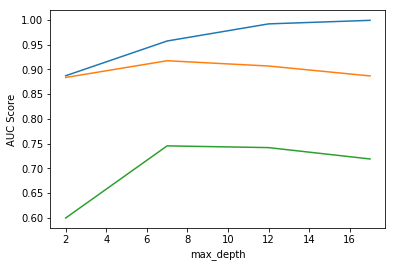

In [160]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(train_results["param_max_depth"], 
         train_results["mean_train_score"], 
         label="train auc score")
plt.plot(train_results["param_max_depth"], 
         train_results["mean_test_score"], 
         label="test auc score")
plt.plot(feature_list, 
         auc_list, 
         label="valid auc score")
plt.xlabel("max_depth")
plt.ylabel("AUC Score")

In [161]:
parameters = {'n_estimators': range(100, 1700, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier()

# fit tree on training data
grid_search = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc',n_jobs=-1)
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

In [162]:
pd.DataFrame(train_results).head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0      13.425728         0.095152         0.920557               1.0   
1      68.064070         0.435667         0.928902               1.0   
2     121.857516         0.779889         0.927641               1.0   
3     165.804114         0.982415         0.928260               1.0   

  param_n_estimators                  params  rank_test_score  \
0                100   {'n_estimators': 100}                4   
1                500   {'n_estimators': 500}                1   
2                900   {'n_estimators': 900}                3   
3               1300  {'n_estimators': 1300}                2   

   split0_test_score  split0_train_score  split1_test_score  \
0           0.926443                 1.0           0.913987   
1           0.930961                 1.0           0.921757   
2           0.929621                 1.0           0.922235   
3           0.929542                 1.0           0.919985   

   split1_train_score  split2_test_score  split2_train_score  \
0                 1.0           0.906242                 1.0   
1                 1.0           0.915717                 1.0   
2                 1.0           0.915024                 1.0   
3                 1.0           0.915534                 1.0   

   split3_test_score  split3_train_score  split4_test_score  \
0           0.929807                 1.0           0.926305   
1           0.937977                 1.0           0.938098   
2           0.936341                 1.0           0.934982   
3           0.936505                 1.0           0.939738   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
0                 1.0      0.419197        0.007438        0.008959   
1                 1.0      0.967296        0.007368        0.008899   
2                 1.0      1.131396        0.019042        0.008023   
3                 1.0     14.989376        0.218293        0.009292   

   std_train_score  
0     0.000000e+00  
1     0.000000e+00  
2     0.000000e+00  
3     4.965068e-17

In [163]:
auc_list = []
feature_list=[]
for feature in range(100, 1700, 400):
    rf = RandomForestClassifier(n_estimators=feature)
    rf.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, rf.predict(X_val))
    auc_list.append(auc(fpr, tpr))
    feature_list.append(feature)

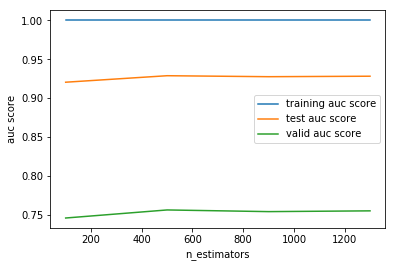

In [164]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(train_results["param_n_estimators"], 
         train_results["mean_train_score"], 
         label="training auc score")
plt.plot(train_results["param_n_estimators"], 
         train_results["mean_test_score"], 
         label="test auc score")
plt.plot(feature_list, 
         auc_list, 
         label="valid auc score")
plt.xlabel("n_estimators")
plt.ylabel("auc score")
plt.legend()
plt.show()

In [165]:
# parameters to build the model on
parameters = {'max_features': range(10, 100, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
grid_search = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc',n_jobs=-1)
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

In [166]:
pd.DataFrame(train_results).head(10)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.691208         0.020117         0.876261          0.999785   
1       1.710656         0.013436         0.881042          0.999761   
2       2.825360         0.017346         0.889285          0.999730   
3       4.483338         0.017947         0.885090          0.999786   
4       4.936935         0.013536         0.892447          0.999795   
5       6.623790         0.014539         0.881426          0.999699   
6       7.996414         0.014338         0.885314          0.999783   
7       9.750546         0.014138         0.883518          0.999675   
8       9.827943         0.013937         0.886924          0.999786   

  param_max_features                params  rank_test_score  \
0                 10  {'max_features': 10}                9   
1                 20  {'max_features': 20}                8   
2                 30  {'max_features': 30}                2   
3                 40  {'max_features': 40}                5   
4                 50  {'max_features': 50}                1   
5                 60  {'max_features': 60}                7   
6                 70  {'max_features': 70}                4   
7                 80  {'max_features': 80}                6   
8                 90  {'max_features': 90}                3   

   split0_test_score  split0_train_score  split1_test_score  \
0           0.874149            0.999751           0.878973   
1           0.888317            0.999701           0.878427   
2           0.887917            0.999776           0.886971   
3           0.871445            0.999803           0.887555   
4           0.902539            0.999802           0.889663   
5           0.889171            0.999791           0.875953   
6           0.895004            0.999774           0.884510   
7           0.886089            0.999770           0.880172   
8           0.895047            0.999703           0.883409   

   split1_train_score  split2_test_score  split2_train_score  \
0            0.999829           0.853829            0.999700   
1            0.999844           0.864587            0.999726   
2            0.999687           0.892821            0.999643   
3            0.999799           0.864175            0.999765   
4            0.999825           0.858893            0.999736   
5            0.999708           0.870257            0.999739   
6            0.999828           0.859038            0.999835   
7            0.999687           0.862889            0.999740   
8            0.999800           0.866458            0.999807   

   split3_test_score  split3_train_score  split4_test_score  \
0           0.881278            0.999755           0.893076   
1           0.891153            0.999766           0.882725   
2           0.890550            0.999735           0.888170   
3           0.911299            0.999784           0.890984   
4           0.906381            0.999792           0.904751   
5           0.887738            0.999607           0.884010   
6           0.901775            0.999756           0.886236   
7           0.894880            0.999701           0.893559   
8           0.898187            0.999755           0.891513   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
0            0.999893      0.114926        0.013871        0.012828   
1            0.999767      0.091837        0.000375        0.009333   
2            0.999808      0.155984        0.005624        0.002125   
3            0.999776      0.276633        0.007852        0.016439   
4            0.999817      0.261390        0.000549        0.017781   
5            0.999649      0.373353        0.001051        0.007228   
6            0.999722      0.458901        0.000401        0.014537   
7            0.999479      0.377075        0.000737        0.011603   
8            0.999864      1.009304        0.003406        0.011358   

   std_train_score  
0         0.0000

In [167]:
auc_list = []
feature_list=[]
for feature in range(10, 100, 10):
    rf = RandomForestClassifier(max_features=feature)
    rf.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, rf.predict(X_val))
    auc_list.append(auc(fpr, tpr))
    feature_list.append(feature)

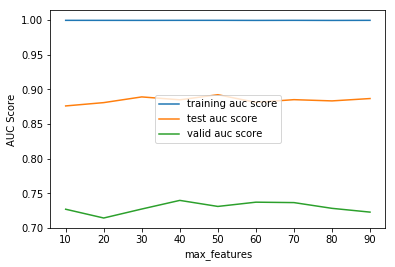

In [168]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(train_results["param_max_features"], 
         train_results["mean_train_score"], 
         label="training auc score")
plt.plot(train_results["param_max_features"], 
         train_results["mean_test_score"], 
         label="test auc score")
plt.plot(feature_list, 
         auc_list, 
         label="valid auc score")
plt.xlabel("max_features")
plt.ylabel("AUC Score")
plt.legend()
plt.show()

In [169]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(10, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


grid_search = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc',n_jobs=-1)
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

In [170]:
pd.DataFrame(train_results).head(10)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.115071         0.016785         0.913600          0.980527   
1       1.225678         0.012333         0.919576          0.968955   
2       0.981692         0.013737         0.917977          0.961858   
3       0.933164         0.016644         0.919459          0.957112   
4       0.912309         0.011731         0.922433          0.952515   
5       0.923739         0.019151         0.920173          0.950206   
6       0.849342         0.017045         0.919812          0.947572   
7       0.847237         0.011731         0.918659          0.944297   
8       0.853253         0.011230         0.917086          0.940479   
9       0.822873         0.013034         0.916308          0.939145   

  param_min_samples_leaf                     params  rank_test_score  \
0                     10   {'min_samples_leaf': 10}               18   
1                     20   {'min_samples_leaf': 20}                4   
2                     30   {'min_samples_leaf': 30}                7   
3                     40   {'min_samples_leaf': 40}                5   
4                     50   {'min_samples_leaf': 50}                1   
5                     60   {'min_samples_leaf': 60}                2   
6                     70   {'min_samples_leaf': 70}                3   
7                     80   {'min_samples_leaf': 80}                6   
8                     90   {'min_samples_leaf': 90}               11   
9                    100  {'min_samples_leaf': 100}               13   

   split0_test_score  split0_train_score  split1_test_score  \
0           0.906818            0.980566           0.912250   
1           0.930918            0.969050           0.917460   
2           0.920987            0.960785           0.915703   
3           0.914289            0.955292           0.912354   
4           0.927248            0.952932           0.917342   
5           0.920383            0.950979           0.917869   
6           0.917899            0.945916           0.914618   
7           0.921183            0.944061           0.912285   
8           0.919456            0.944965           0.910770   
9           0.918838            0.937301           0.912099   

   split1_train_score  split2_test_score  split2_train_score  \
0            0.981667           0.902814            0.981184   
1            0.969444           0.900094            0.969396   
2            0.963247           0.897891            0.962907   
3            0.957718           0.910647            0.957053   
4            0.953265           0.911369            0.953816   
5            0.950825           0.906778            0.950291   
6            0.947850           0.907635            0.950332   
7            0.943097           0.904300            0.944686   
8            0.941018           0.904913            0.938534   
9            0.940307           0.903510            0.940053   

   split3_test_score  split3_train_score  split4_test_score  \
0           0.918864            0.980108           0.927259   
1           0.922772            0.968400           0.926628   
2           0.928081            0.962050           0.927220   
3           0.927768            0.958726           0.932242   
4           0.926034            0.951487           0.930169   
5           0.928621            0.950579           0.927217   
6           0.927295            0.946716           0.931614   
7           0.924873            0.944937           0.930655   
8           0.925675            0.939884           0.924619   
9           0.923835            0.939138           0.923259   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
0            0.979110      0.329143        0.007228        0.008699   
1            0.968483      0.166314        0.000680        0.010701   
2            0.960301      0.061874        0.002683        0.011001   
3            0.956771      0.044477     

In [171]:
auc_list = []
feature_list=[]
for feature in range(10, 400, 10):
    rf = RandomForestClassifier(min_samples_leaf=feature)
    rf.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, rf.predict(X_val))
    auc_list.append(auc(fpr, tpr))
    feature_list.append(feature)

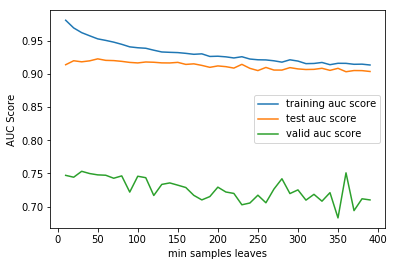

In [172]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(train_results["param_min_samples_leaf"], 
         train_results["mean_train_score"], 
         label="training auc score")
plt.plot(train_results["param_min_samples_leaf"], 
         train_results["mean_test_score"], 
         label="test auc score")
plt.plot(feature_list, 
         auc_list, 
         label="valid auc score")
plt.xlabel("min samples leaves")
plt.ylabel("AUC Score")
plt.legend()
plt.show()

In [173]:
# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
grid_search = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc',n_jobs=-1)
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

In [174]:
pd.DataFrame(train_results).head(10)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.097312         0.008423         0.918192          0.959734   
1       1.300338         0.011430         0.916701          0.954974   
2       1.323093         0.020254         0.917806          0.952432   
3       1.295721         0.013536         0.916581          0.949713   
4       1.425263         0.011530         0.919361          0.946652   
5       1.001544         0.011029         0.913987          0.944893   

  param_min_samples_split                      params  rank_test_score  \
0                     200  {'min_samples_split': 200}                2   
1                     250  {'min_samples_split': 250}                4   
2                     300  {'min_samples_split': 300}                3   
3                     350  {'min_samples_split': 350}                5   
4                     400  {'min_samples_split': 400}                1   
5                     450  {'min_samples_split': 450}                6   

   split0_test_score  split0_train_score  split1_test_score  \
0           0.926073            0.961101           0.914665   
1           0.918218            0.954873           0.913628   
2           0.915713            0.950536           0.914445   
3           0.912022            0.949153           0.916709   
4           0.922628            0.948399           0.916260   
5           0.915167            0.942686           0.913733   

   split1_train_score  split2_test_score  split2_train_score  \
0            0.959326           0.899193            0.959658   
1            0.954708           0.897270            0.954160   
2            0.952902           0.904903            0.956461   
3            0.951067           0.905748            0.951910   
4            0.948605           0.906653            0.946547   
5            0.949995           0.896441            0.943142   

   split3_test_score  split3_train_score  split4_test_score  \
0           0.923419            0.960705           0.927607   
1           0.928275            0.957154           0.926117   
2           0.929872            0.952267           0.924097   
3           0.923736            0.949066           0.924695   
4           0.923377            0.947027           0.927884   
5           0.920953            0.945372           0.923641   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
0            0.957881      0.348505        0.004599        0.010501   
1            0.953975      0.135455        0.000491        0.011062   
2            0.949994      0.080851        0.013996        0.008570   
3            0.947371      0.083986        0.002615        0.007144   
4            0.942682      0.187858        0.000549        0.007356   
5            0.943273      0.066717        0.000448        0.009497   

   std_train_score  
0         0.001133  
1         0.001140  
2         0.002281  
3         0.001605  
4         0.002134  
5         0.002714

In [175]:
auc_list = []
feature_list=[]
for feature in range(200, 500, 50):
    rf = RandomForestClassifier(min_samples_split=feature)
    rf.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, rf.predict(X_val))
    auc_list.append(auc(fpr, tpr))
    feature_list.append(feature)

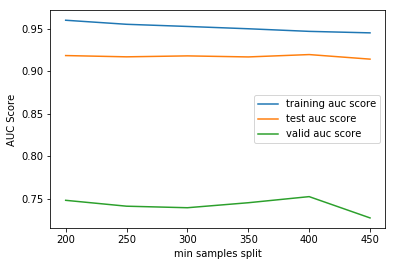

In [176]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(train_results["param_min_samples_split"], 
         train_results["mean_train_score"], 
         label="training auc score")
plt.plot(train_results["param_min_samples_split"], 
         train_results["mean_test_score"], 
         label="test auc score")
plt.plot(feature_list, 
         auc_list, 
         label="valid auc score")
plt.xlabel("min samples split")
plt.ylabel("AUC Score")
plt.legend()
plt.show()

In [ ]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [7],
    'min_samples_leaf': range(300, 400, 10),
    'min_samples_split': range(350, 450, 10),
    'n_estimators': [500], 
    'max_features': range(30, 50, 5),
    "bootstrap": [True],    
}
scoring = {'AUC': 'roc_auc'}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, scoring='roc_auc',  verbose=10)
grid_search.fit(X_train, y_train)
train_results = grid_search.cv_results_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 33.2min
[Paralle